# ResNet18-2d+LSTM

In [ ]:
import pandas as pd
import numpy as np
import random
import os
import torch
from collections import Counter, defaultdict
from tqdm import tqdm

import os
import json

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
import torchvision.models.video as models
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import cv2
from google.colab.patches import cv2_imshow

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); device

device(type='cpu')

In [ ]:
df_elements = pd.read_excel('/content/drive/MyDrive/ПМ/диплом/диплом/Datasets/Датасет в модель.xlsx')
df_elements

,BD_path,BD_label,video_name
0,/content/drive/MyDrive/диплом/Video silhouette...,15,поворот пассе — сделано в Clipchamp_0.mp4
1,/content/drive/MyDrive/диплом/Video silhouette...,15,Диана Чугунихина поворт пассе — сделано в Clip...
2,/content/drive/MyDrive/диплом/Video silhouette...,15,Диана Чугунихина поворт пассе — сделано в Clip...
3,/content/drive/MyDrive/диплом/Video silhouette...,15,Диана Чугунихина поворт пассе — сделано в Clip...
4,/content/drive/MyDrive/диплом/Video silhouette...,15,Диана Чугунихина поворт пассе — сделано в Clip...
...,...,...,...
6227,/content/drive/MyDrive/диплом/Video silhouette...,78,Саша_Семенова равновесие вперед 90 — сделано в...
6228,/content/drive/MyDrive/диплом/Video silhouette...,78,Саша_Семенова равновесие вперед 90 — сделано в...
6229,/content/drive/MyDrive/диплом/Video silhouette...,78,Саша_Семенова равновесие вперед 90 — сделано в...
6230,/content/drive/MyDrive/диплом/Video silhouette...,78,Саша_Семенова равновесие вперед 90 — сделано в...


In [ ]:
save_path = '/content/drive/MyDrive/ПМ/диплом/диплом'
os.makedirs(save_path, exist_ok=True)

In [ ]:
df_elements['BD_path'][0]

'/content/drive/MyDrive/диплом/Video silhouettes new/поворот пассе — сделано в Clipchamp_0.mp4'

In [ ]:
new_root = '/content/drive/MyDrive/ПМ/диплом/диплом/Video silhouettes new'
df_elements['BD_path'] = df_elements['BD_path'].apply(lambda x: os.path.join(new_root, os.path.basename(x)))

In [ ]:
cap = cv2.VideoCapture(df_elements['BD_path'][0])
cap.isOpened()

In [ ]:
class VideoDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.label2idx = {label: idx for idx, label in enumerate(sorted(dataframe['BD_label'].unique()))}
        self.idx2label = {idx: label for label, idx in self.label2idx.items()}

    def __len__(self):
        return len(self.dataframe)

    def read_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (112, 112))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()

        # (T x C x H x W)
        frames = np.array(frames).astype(np.float32) / 255.0
        frames = torch.from_numpy(frames).permute(0, 3, 1, 2)  # T C H W
        return frames

    def __getitem__(self, idx):
        video_path = self.dataframe.loc[idx, 'BD_path']
        label = self.dataframe.loc[idx, 'BD_label']
        label_idx = self.label2idx[label]

        video = self.read_video(video_path)
        if self.transform:
            video = self.transform(video)
        return video, label_idx

In [ ]:
def get_sampler(labels):
    label_counts = Counter(labels)
    weights = [1.0 / label_counts[label] for label in labels]
    return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, hidden_size, num_classes, cnn_dim=512):
        super(CNN_LSTM, self).__init__()
        # CNN
        resnet = models.resnet18(pretrained = True)
        resnet.fc = nn.Identity() # удаление слоя fc

        # заморозка всех слоев
        for name, param in resnet.named_parameters():
            param.requires_grad_(False)
        # разморозка нижних слоев
        for param in resnet.layer3.parameters():
            param.requires_grad = True
        for param in resnet.layer4.parameters():
            param.requires_grad = True
        for param in resnet.fc.parameters():
            param.requires_grad = True

        self.cnn = nn.Sequential(resnet)
        self.cnn_dim = cnn_dim

        # LSTM
        self.lstm = nn.LSTM(input_size = cnn_dim, hidden_size = hidden_size,
                            num_layers = 1, batch_first = True)

        # fc
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x): # x: [B, T, C, H, W]
        B, T, C, H, W = x.shape
        # объединание батчей и кадров для cnn
        x = x.reshape(B * T, C, H, W)
        out = self.cnn(x).squeeze(-1).squeeze(-1)  # [B*T, 512]
        out = out.view(B, T, -1) # [B, T, 512]
        lstm_out, _ = self.lstm(out)  # [B, T, hidden_size]
        out = self.fc(lstm_out[:, -1, :])  # [B, num_classes]

        return out

In [ ]:
# выравниваем разную длительность до максимальной паддингом, заполняем нулями
def collate_fn(batch):
    # паддинг до максимальной длины в батче
    max_len = max([video.shape[0] for video, _ in batch])  # vмакс длительность видео в батче
    padded_videos = []
    labels = []
    for video, label in batch:
        pad_len = max_len - video.shape[0]  # оставшееся время до макс длительности
        if pad_len > 0:
            pad = torch.zeros((pad_len, 3, 112, 112))  # заполняем нулями
            video = torch.cat([video, pad], dim=0)   # конкатим исхолдное и дополненное черное видео
        padded_videos.append(video)
        labels.append(label)
    videos = torch.stack(padded_videos) # B, T, C, H, W
    labels = torch.tensor(labels)  # в тензор
    return videos, labels

In [ ]:
batch_size = 4

In [ ]:
train, test = train_test_split(df_elements,
                               test_size = 0.2,
                               stratify = df_elements['BD_label'],
                               random_state = 42
                               )

In [ ]:
train_dataset = VideoDataset(train)
test_dataset = VideoDataset(test)

In [ ]:
train_sampler = get_sampler(train['BD_label'])
train_loader = DataLoader(train_dataset, batch_size = batch_size, sampler=train_sampler, collate_fn = collate_fn)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, collate_fn = collate_fn)

Обучение

In [ ]:
%%time
num_epochs = 11
hidden_size = 128
num_classes = len(df_elements['BD_label'].unique())

model = CNN_LSTM(hidden_size=hidden_size, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
losses = []
accuracy_train, accuracy_test = [], []
f1_train, f1_test = [], []
precision_train, precision_test =  [], []
recall_train, recall_test = [], []


for epoch in range(num_epochs):
    model.train()
    train_preds, train_labels = [], []

    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        out = model(inputs)
        loss = criterion(out, targets)
        loss.backward()
        optimizer.step()

        train_preds.extend(torch.argmax(out, dim=1).cpu().numpy())
        train_labels.extend(targets.cpu().numpy())

    losses.append(loss.item())

    model.eval()
    test_preds, test_labels = [], []

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            out = model(inputs)

            test_preds.extend(torch.argmax(out, dim=1).cpu().numpy())
            test_labels.extend(targets.cpu().numpy())

    acc_train = accuracy_score(train_labels, train_preds)
    acc_test = accuracy_score(test_labels, test_preds)

    f1_tr = f1_score(train_labels, train_preds, average='macro', zero_division=0)
    f1_te = f1_score(test_labels, test_preds, average='macro', zero_division=0)

    prec_tr = precision_score(train_labels, train_preds, average='macro', zero_division=0)
    prec_te = precision_score(test_labels, test_preds, average='macro', zero_division=0)

    rec_tr = recall_score(train_labels, train_preds, average='macro', zero_division=0)
    rec_te = recall_score(test_labels, test_preds, average='macro', zero_division=0)

    accuracy_train.append(acc_train)
    accuracy_test.append(acc_test)
    f1_train.append(f1_tr)
    f1_test.append(f1_te)
    precision_train.append(prec_tr)
    precision_test.append(prec_te)
    recall_train.append(rec_tr)
    recall_test.append(rec_te)

    torch.save(model.state_dict(), os.path.join(save_path, f'model_epoch_{epoch+1}_cnn_rnn.pth'))

    checkpoint = {
        'epoch': epoch + 1,  # следующий номер эпохи
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item()
    }

    torch.save(checkpoint, os.path.join(save_path, f'checkpoint_epoch_{epoch+1}_cnn_rnn.pth'))

    epoch_metrics = {
        'epoch': epoch + 1,
        'loss': loss.item(),
        'accuracy_train': acc_train,
        'accuracy_test': acc_test,
        'f1_train': f1_tr,
        'f1_test': f1_te,
        'precision_train': prec_tr,
        'precision_test': prec_te,
        'recall_train': rec_tr,
        'recall_test': rec_te
    }

    with open(os.path.join(save_path, f'metrics_epoch_{epoch+1}.json'), 'w') as f:
        json.dump(epoch_metrics, f, indent=4)

    print(f"{epoch + 1}/{num_epochs} Loss: {loss.item():.4f}, "
          f"Train Accuracy: {accuracy_train[-1]:.4f}, "
          f"Test Accuracy: {accuracy_test[-1]:.4f}, "
          f"Train F1: {f1_train[-1]:.4f}, "
          f"Test F1: {f1_test[-1]:.4f}"
          f"Train Precision: {precision_train[-1]:.4f}, "
          f"Test Precision: {precision_test[-1]:.4f}, "
          f"Train Recall: {recall_train[-1]:.4f}, "
          f"Test Recall: {recall_test[-1]:.4f}, "
        )

models_metrics = {
    'losses': losses,
    'accuracy_train': accuracy_train,
    'accuracy_test': accuracy_test,
    'f1_train': f1_train,
    'f1_test': f1_test,
    'precision_train': precision_train,
    'precision_test': precision_test,
    'recall_train': recall_train,
    'recall_test': recall_test
}

with open(os.path.join(save_path, 'training_history_cnn_rnn.json'), 'w') as f:
    json.dump(models_metrics, f, indent=4)

100%|██████████| 312/312 [26:28<00:00,  5.09s/it]


7/10 Loss: 1.6026, Train Accuracy: 0.6148, Test Accuracy: 0.4242, Train F1: 0.5870, Test F1: 0.4132 Train Precision: 0.5984, Test Precision: 0.4366, Train Recall: 0.6114, Test Recall: 0.4943, 


  4%|▍         | 47/1247 [01:32<21:16,  1.06s/it]

In [ ]:
json_files = ['/content/drive/MyDrive/ПМ/диплом/диплом/metrics_epoch_1.json',
              '/content/drive/MyDrive/ПМ/диплом/диплом/metrics_epoch_2.json',
              '/content/drive/MyDrive/ПМ/диплом/диплом/metrics_epoch_3.json',
              '/content/drive/MyDrive/ПМ/диплом/диплом/metrics_epoch_4.json',
              '/content/drive/MyDrive/ПМ/диплом/диплом/metrics_epoch_5.json',
              '/content/drive/MyDrive/ПМ/диплом/диплом/metrics_epoch_6.json',
              '/content/drive/MyDrive/ПМ/диплом/диплом/metrics_epoch_7.json',
              '/content/drive/MyDrive/ПМ/диплом/диплом/metrics_epoch_8.json',
              '/content/drive/MyDrive/ПМ/диплом/диплом/metrics_epoch_9.json',
              '/content/drive/MyDrive/ПМ/диплом/диплом/metrics_epoch_10.json',
              '/content/drive/MyDrive/ПМ/диплом/диплом/metrics_epoch_11.json'
              ]

merged_metrics = defaultdict(list)

for file_path in json_files:
    with open(file_path, 'r') as f:
        data = json.load(f)
        for key, value in data.items():
            merged_metrics[key].append(value)

dict_merged_metrics = dict(merged_metrics);\

losses = dict_merged_metrics['loss']
accuracy_train, accuracy_test = dict_merged_metrics['accuracy_train'], dict_merged_metrics['accuracy_test']
f1_train, f1_test = dict_merged_metrics['f1_train'], dict_merged_metrics['f1_test']
precision_train, precision_test =  dict_merged_metrics['precision_train'], dict_merged_metrics['precision_test']
recall_train, recall_test = dict_merged_metrics['recall_train'], dict_merged_metrics['recall_test']

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = list(range(1, num_epochs + 1)),
                         y = losses,
                         mode = 'lines')
                )

fig.update_layout(title = "График функции потерь",
                  xaxis_title = "Epoch",
                  yaxis_title = "Loss",
                  paper_bgcolor='black',
                  plot_bgcolor='black',
                  font=dict(color='white'),
                  legend=dict(bgcolor='black')
                  )

fig.show()

In [ ]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Accuracy", "F1-score", "Recall", "Precision")
)

metrics = [
    (accuracy_train, accuracy_test, 1, 1),
    (f1_train, f1_test, 1, 2),
    (recall_train, recall_test, 2, 1),
    (precision_train, precision_test, 2, 2)
]

for train_metric, test_metric, row, col in metrics:
    fig.add_trace(go.Scatter(x=list(range(1, num_epochs + 1)),
                             y=train_metric,
                             mode='lines',
                             name='train'),
                  row=row, col=col)

    fig.add_trace(go.Scatter(x=list(range(1, num_epochs + 1)),
                             y=test_metric,
                             mode='lines',
                             name='test'),
                  row=row, col=col)

fig.update_layout(
    title="Метрики",
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    legend=dict(bgcolor='black')
)

for i in range(1, 5):
    fig.update_xaxes(showgrid=True, gridcolor='gray', color='white', row=(i-1)//2+1, col=(i-1)%2+1)
    fig.update_yaxes(showgrid=True, gridcolor='gray', color='white', row=(i-1)//2+1, col=(i-1)%2+1)

fig.show()


In [ ]:
le = LabelEncoder()

In [ ]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for videos, labels in tqdm(test_loader):

        videos, labels = videos.to(device), labels.to(device)

        outputs = model(videos)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

label_names = [str(i) for i in range(df_elements['BD_label'].nunique())]


In [ ]:
def play_video(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Не удалось открыть видео")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        cv2_imshow(frame)

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
def predict_video(model, video_path, dataset, device='cuda'):
    model.eval()

    video = dataset.read_video(video_path)  # T, C, H, W
    label = dataset.dataframe[dataset.dataframe['BD_path'] == video_path]['BD_label'].values[0]

    video = video.unsqueeze(0).to(device)  # 1, T, C, H, W

    with torch.no_grad():
        output = model(video)
        pred = torch.argmax(output, dim=1).item()

    return label, pred

In [ ]:
checkpoint_path = os.path.join('/content/drive/MyDrive/ПМ/диплом/диплом/checkpoint_epoch_11_cnn_rnn.pth')
checkpoint = torch.load(checkpoint_path, map_location=device)

model = CNN_LSTM(hidden_size=hidden_size, num_classes=num_classes).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
ind = random.randint(0, len(test_dataset) - 1)
video_path = test_dataset.dataframe.loc[ind, 'BD_path']
ind, video_path

(89,
 '/content/drive/MyDrive/ПМ/диплом/диплом/Video silhouettes new/Вика_Чумакова поворот переднее кольцо — сделано в Clipchamp (1) (1)_511.mp4')

Истинный класс : 9
Предсказанный класс : 9


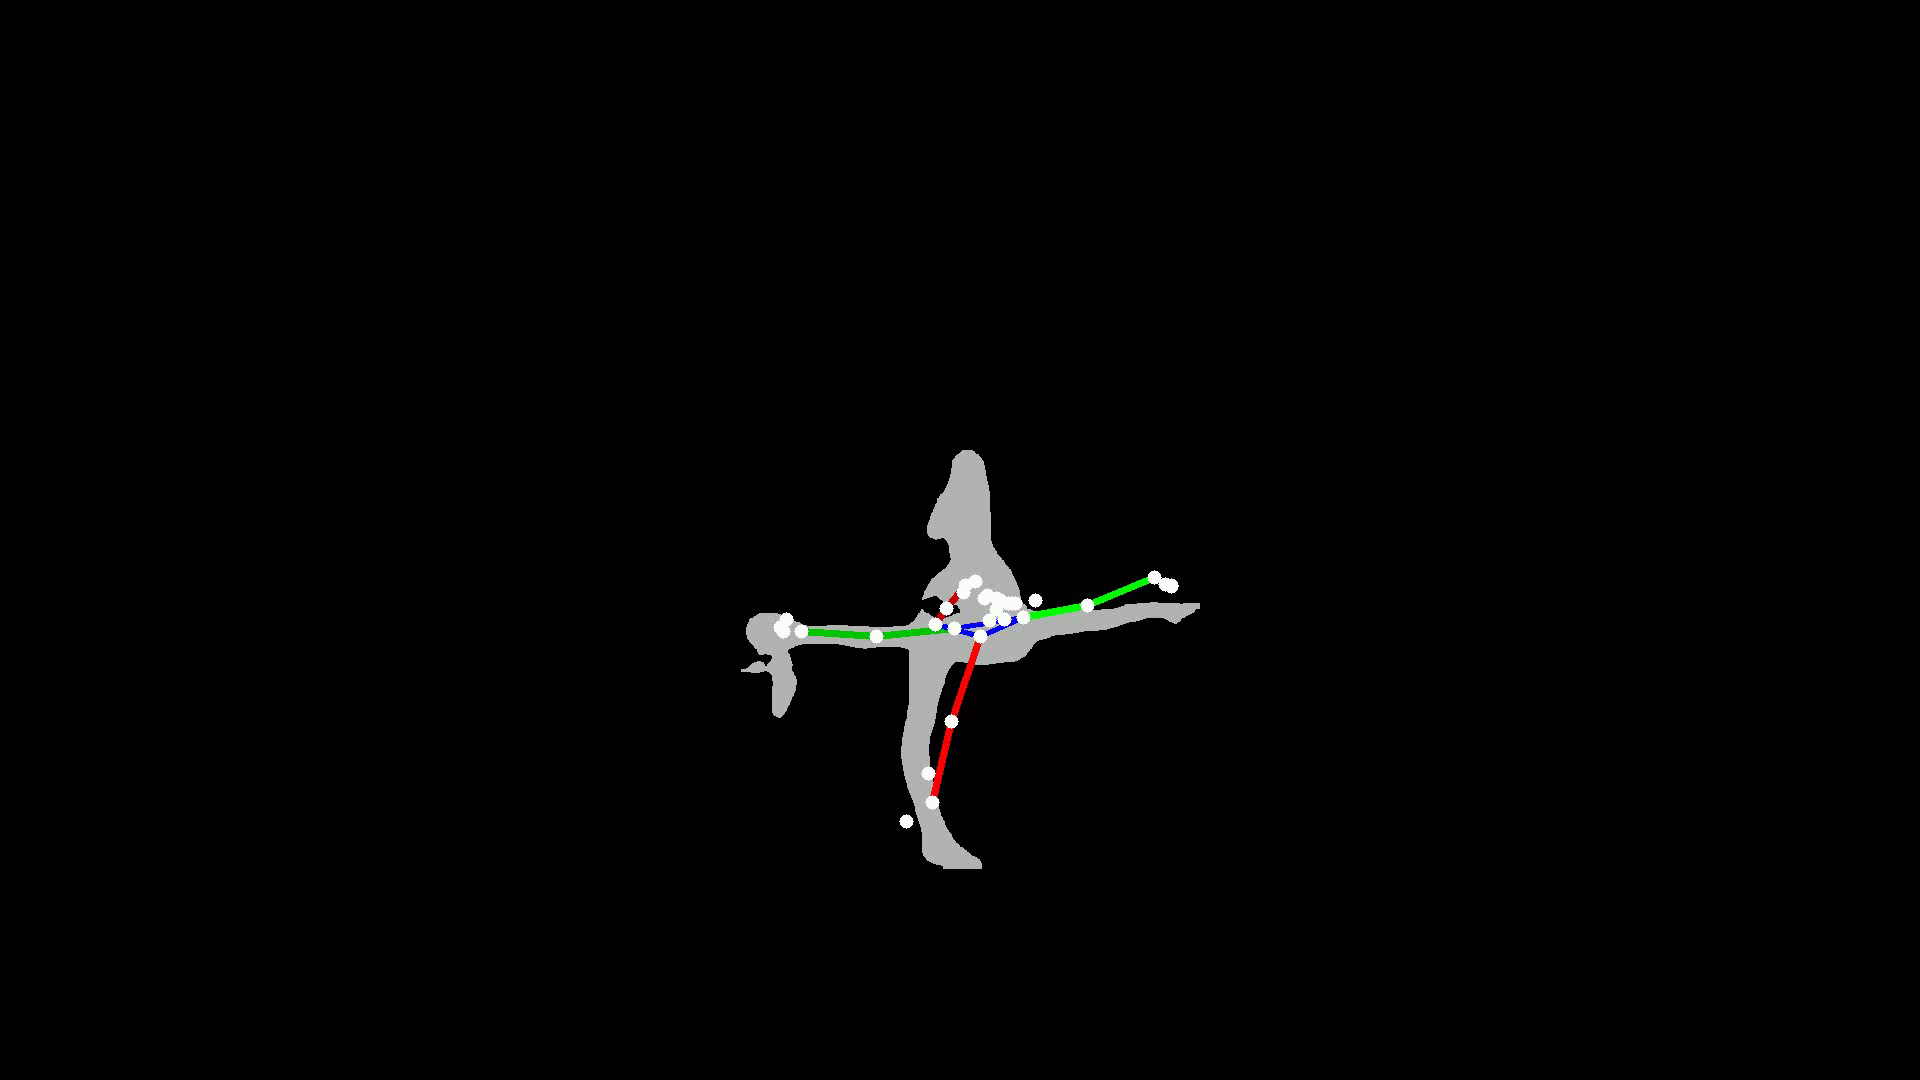

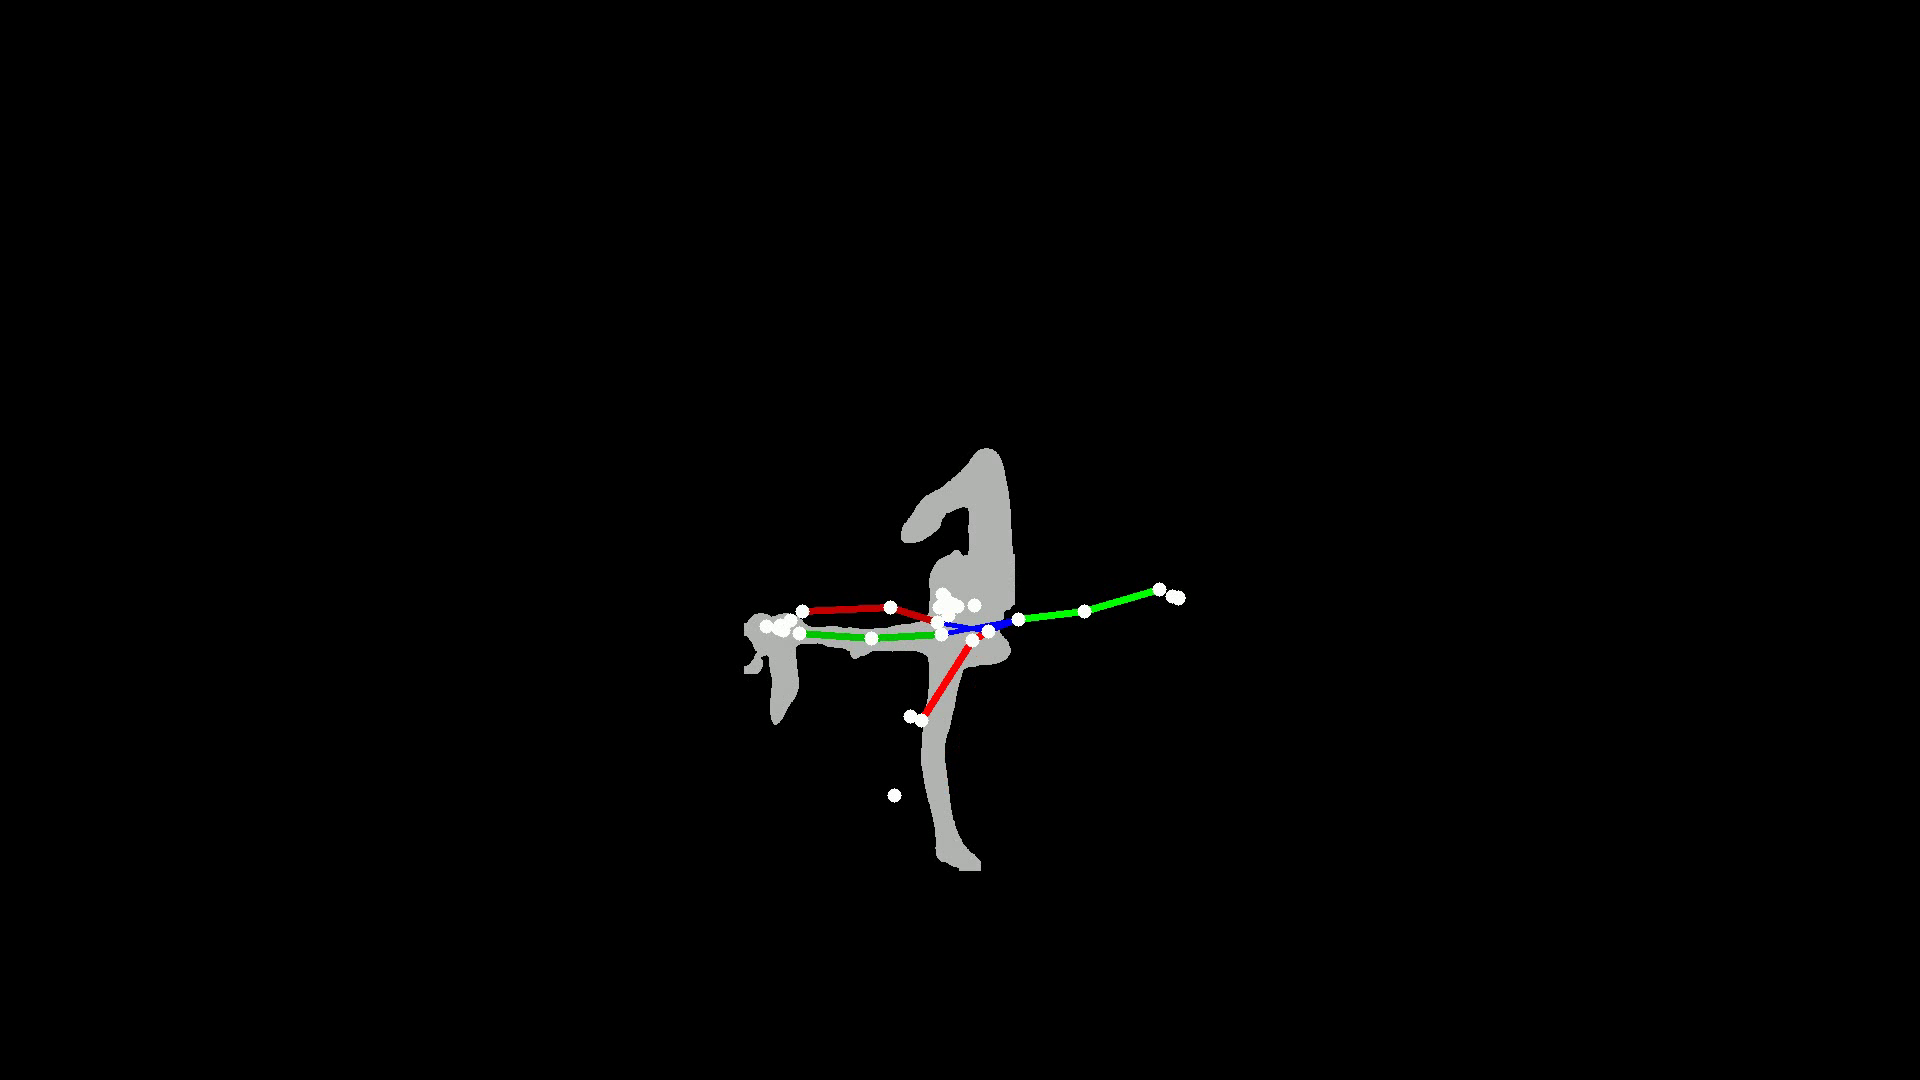

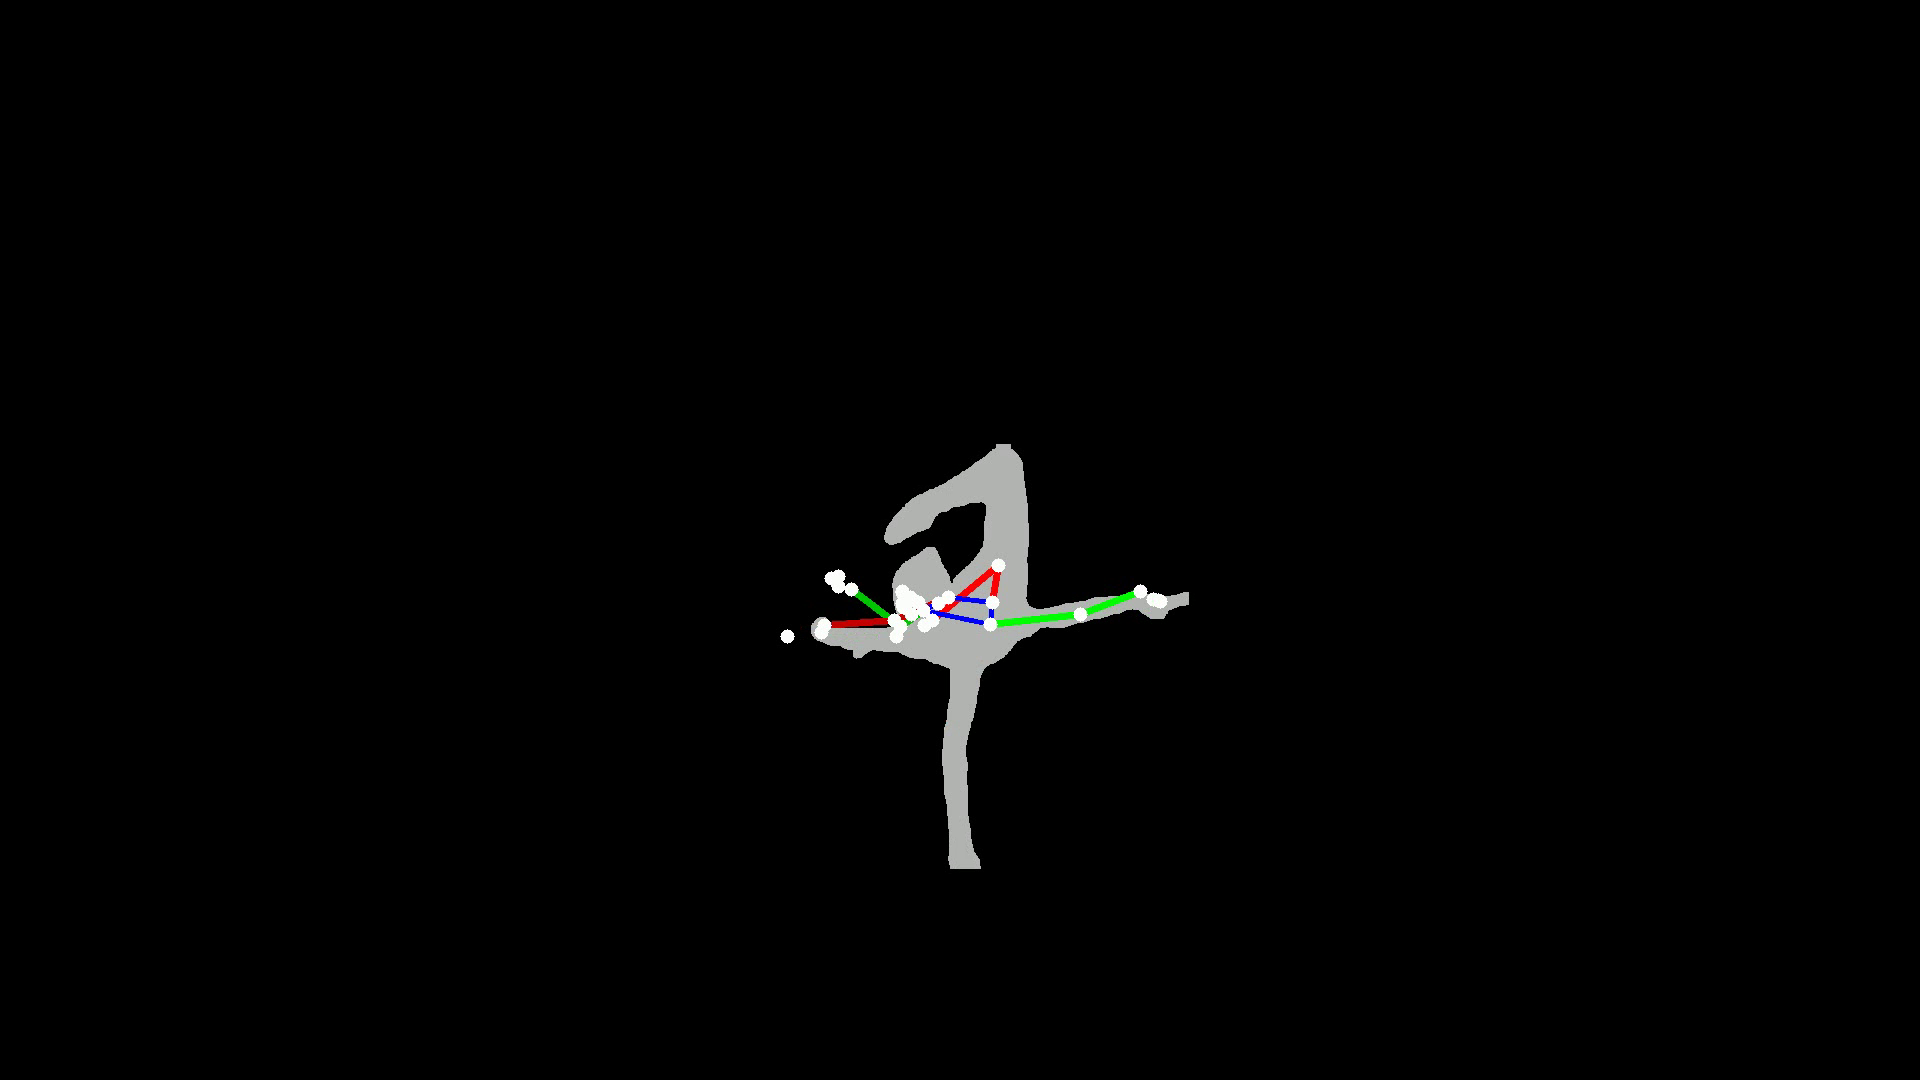

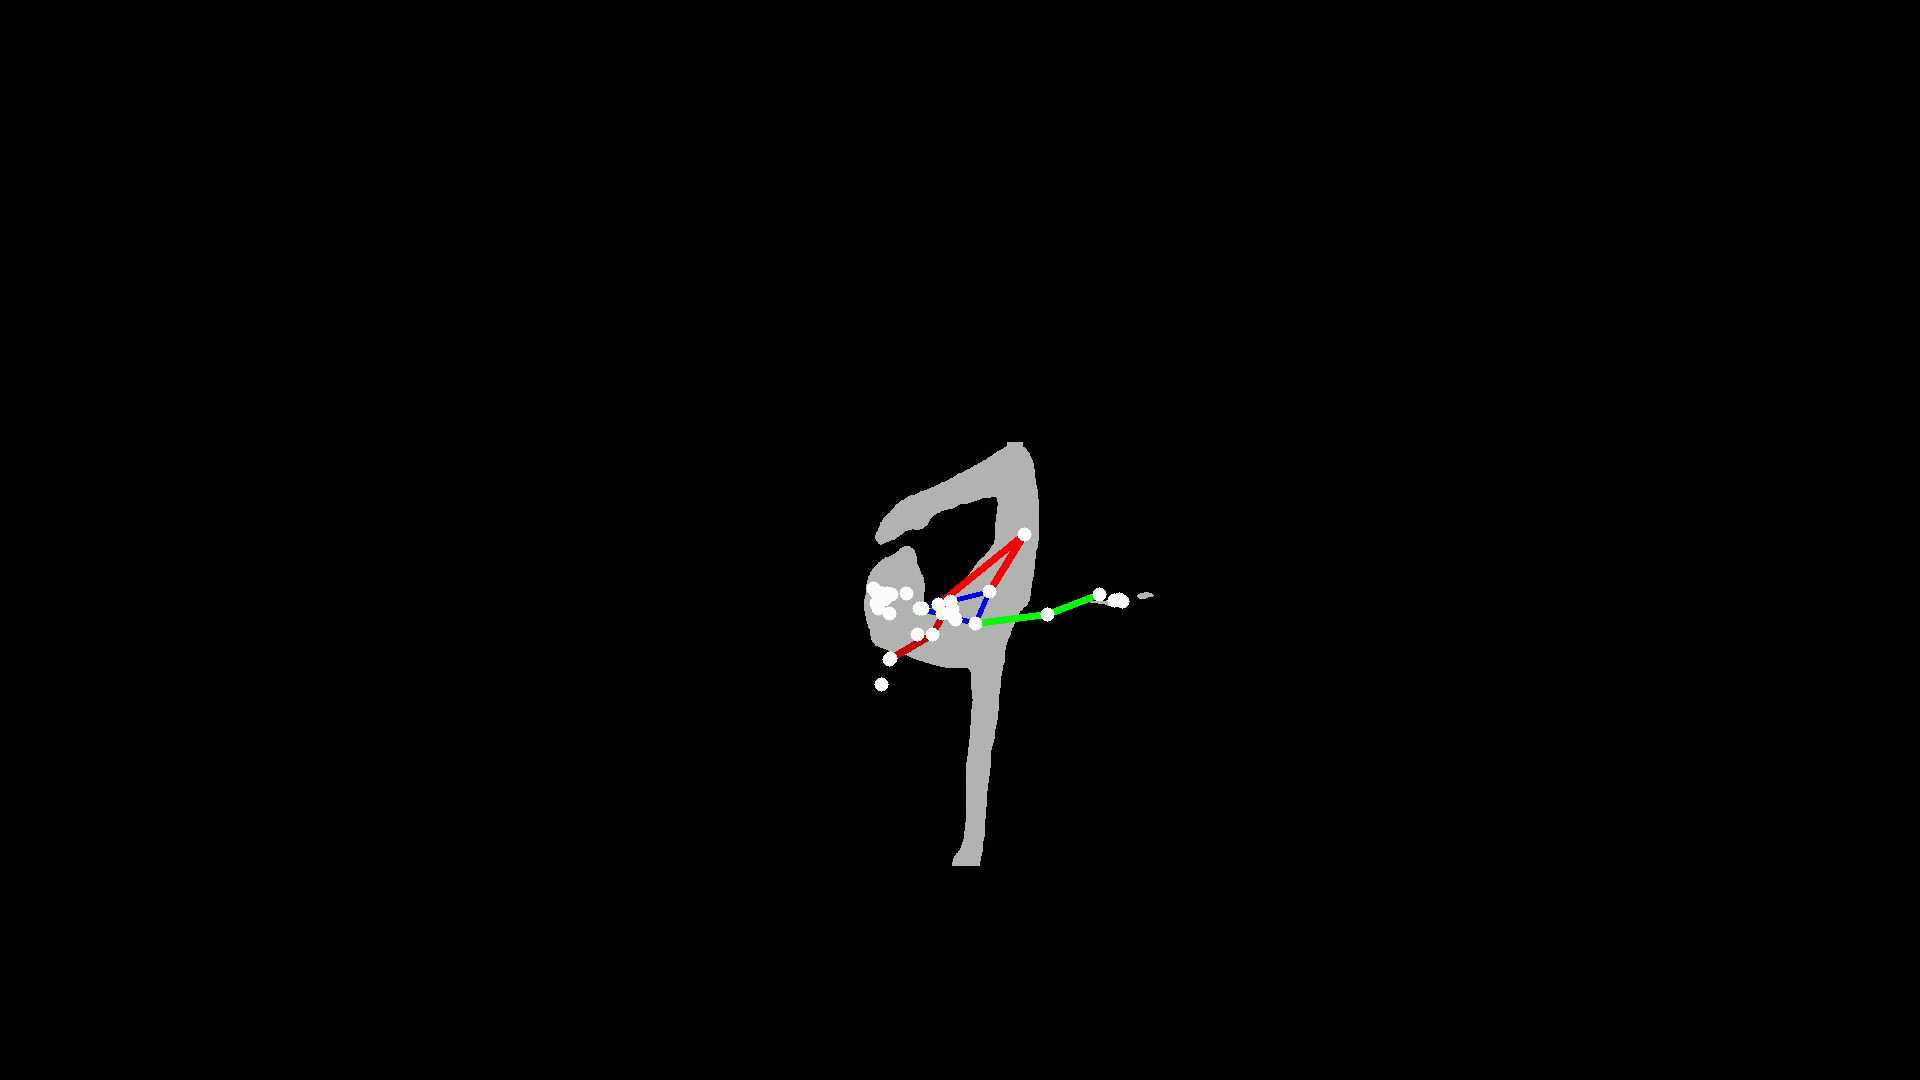

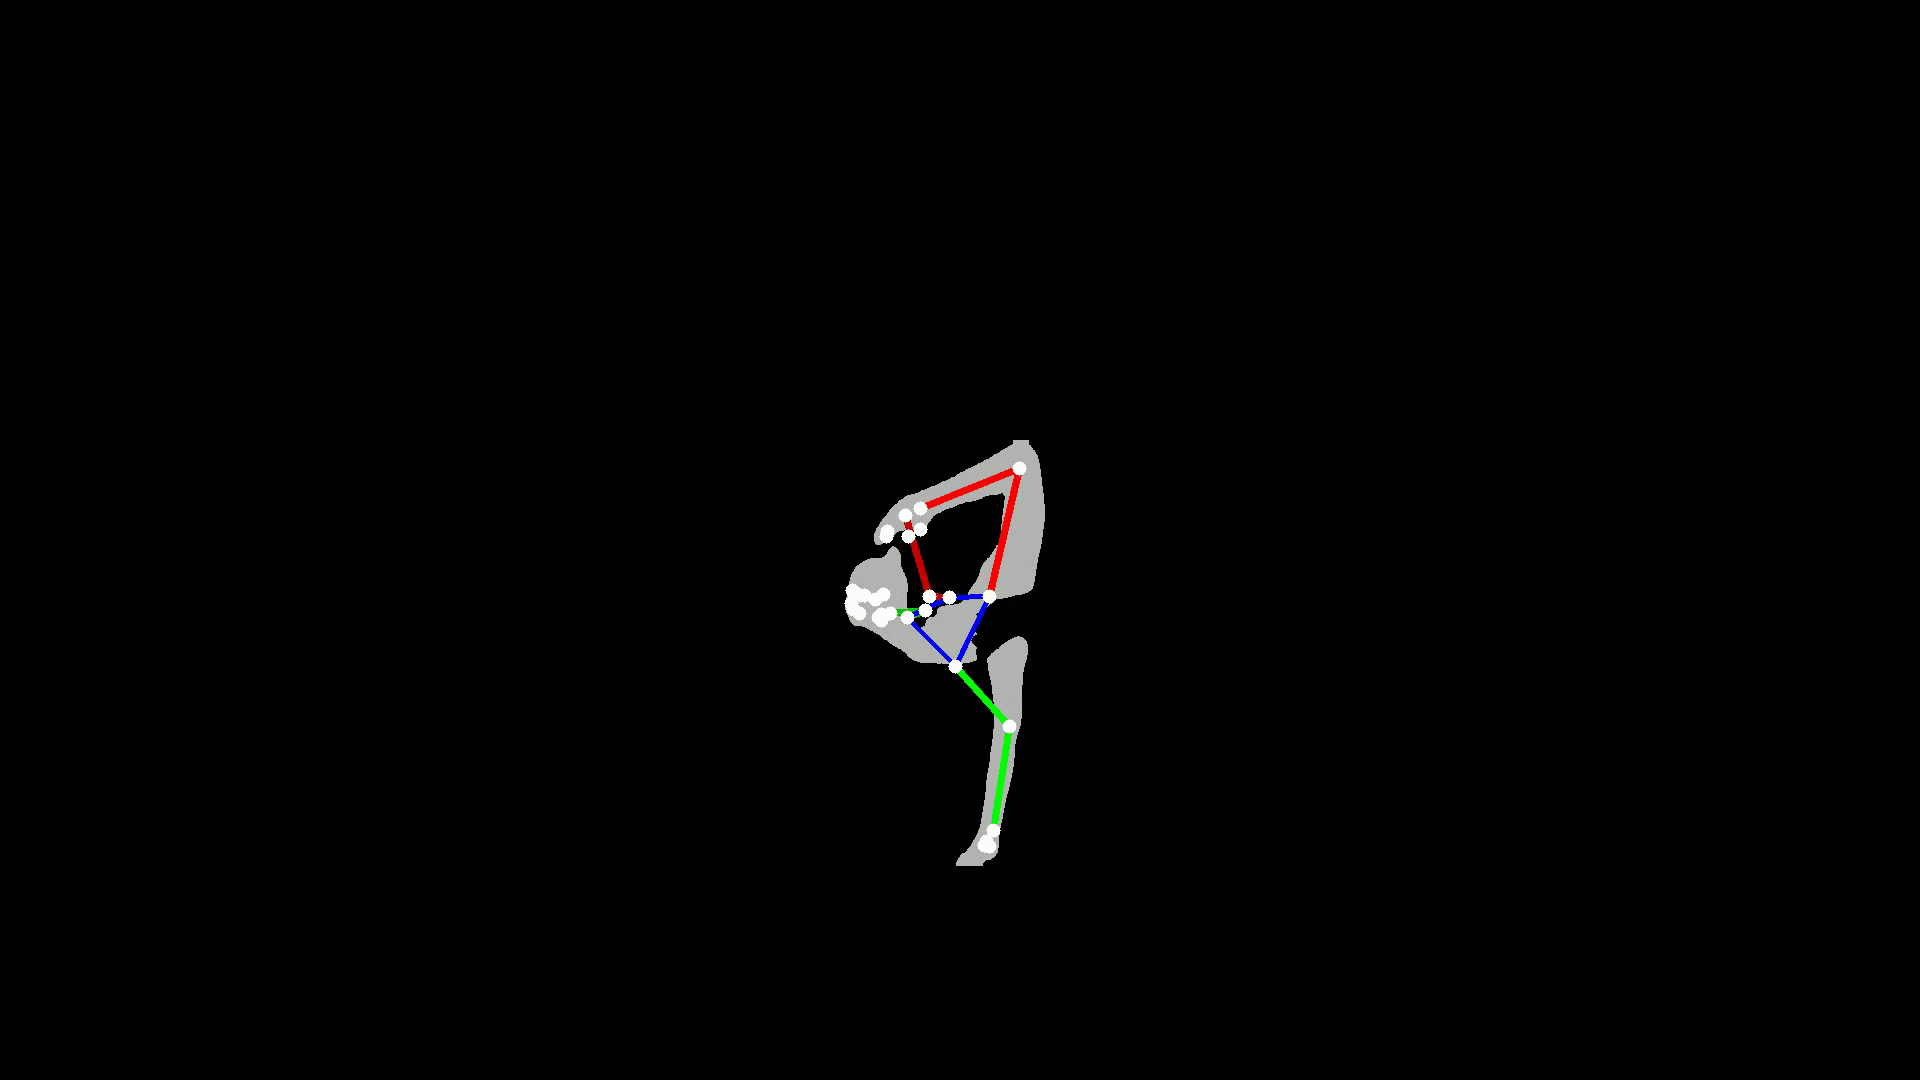

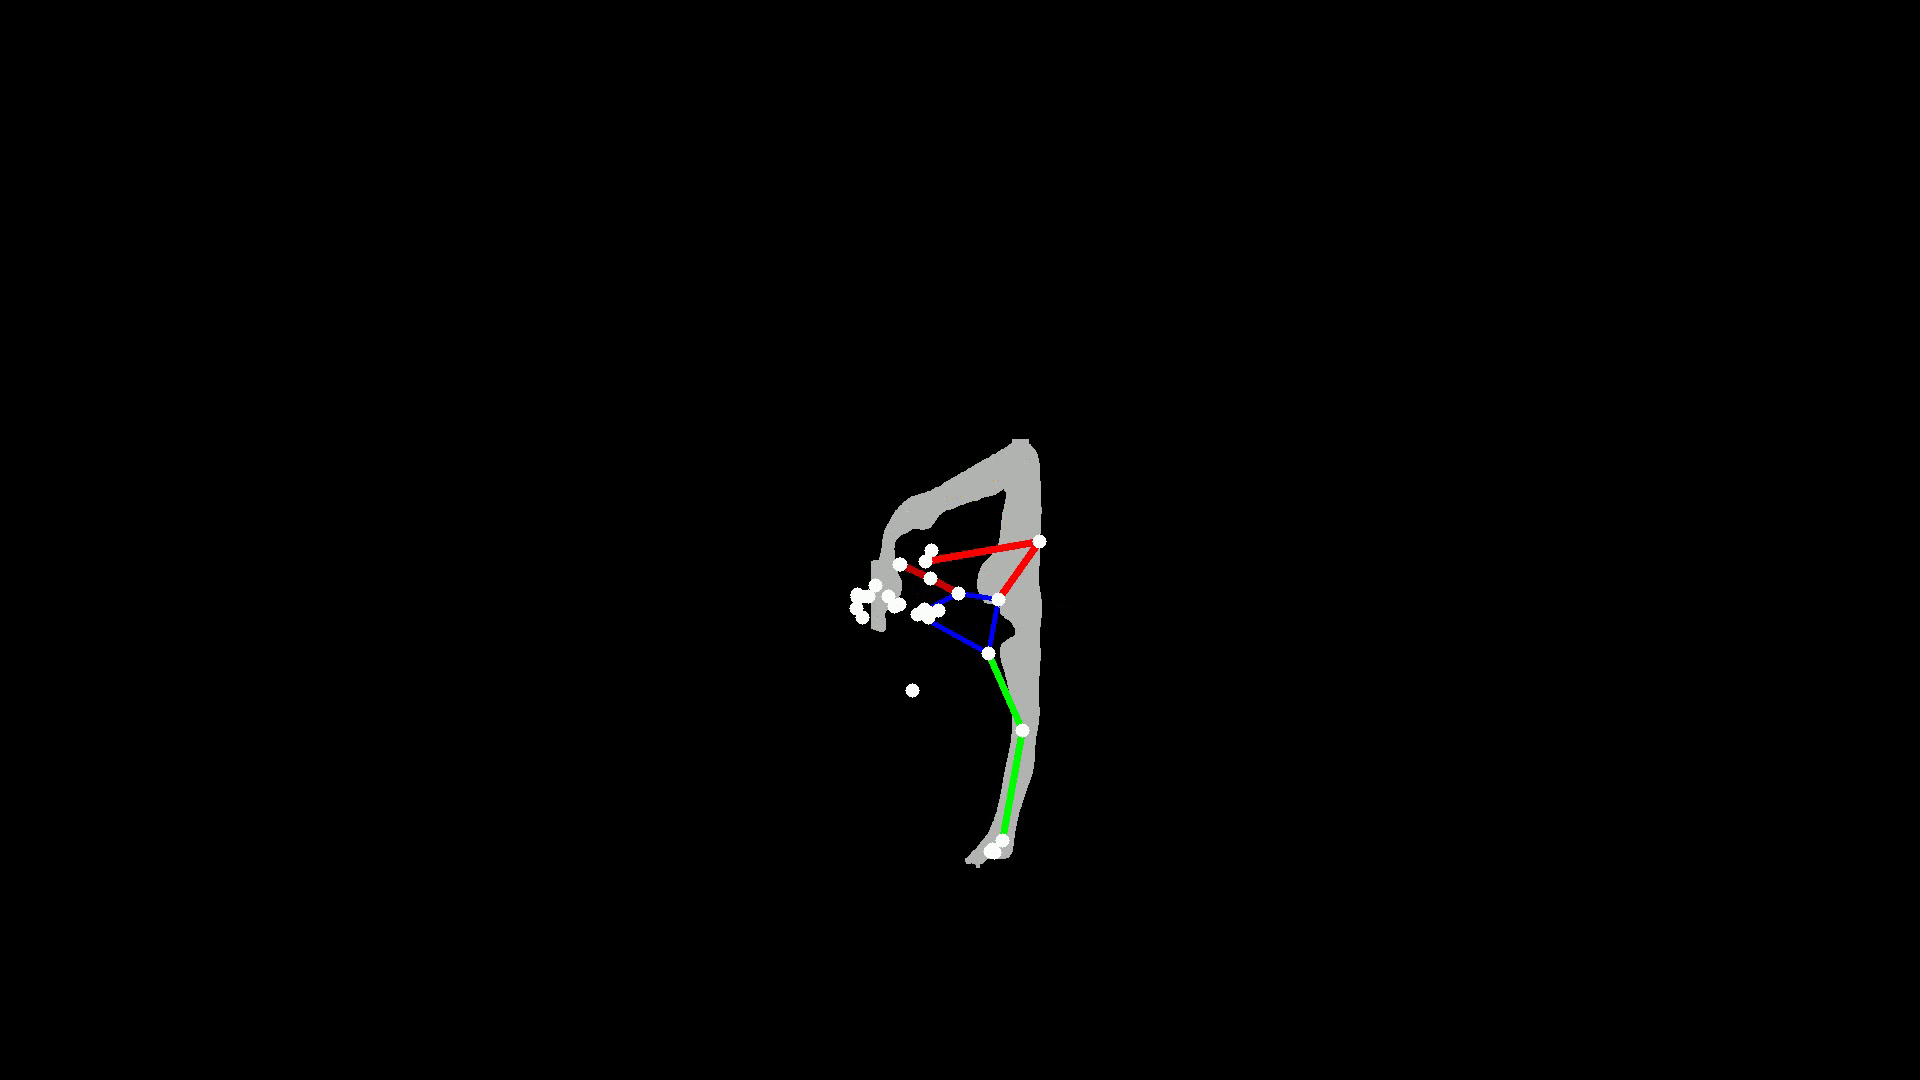

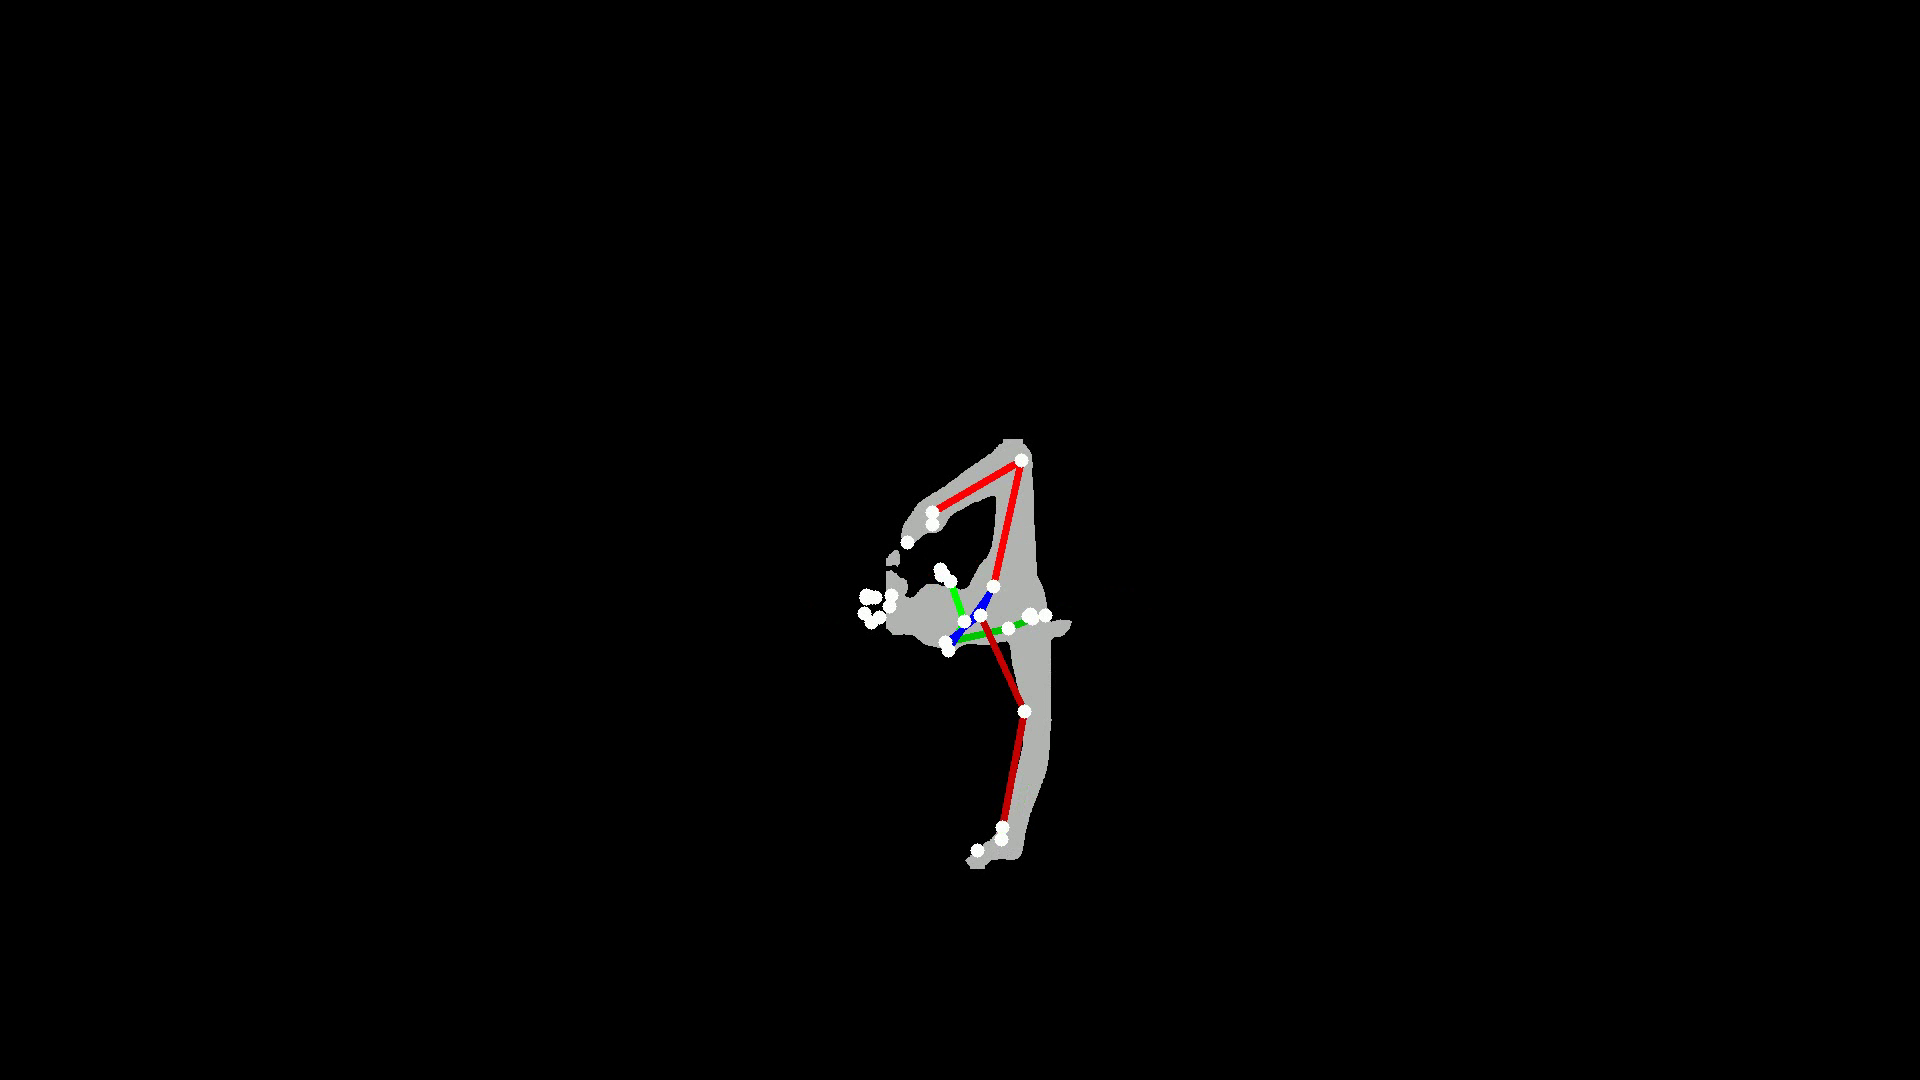

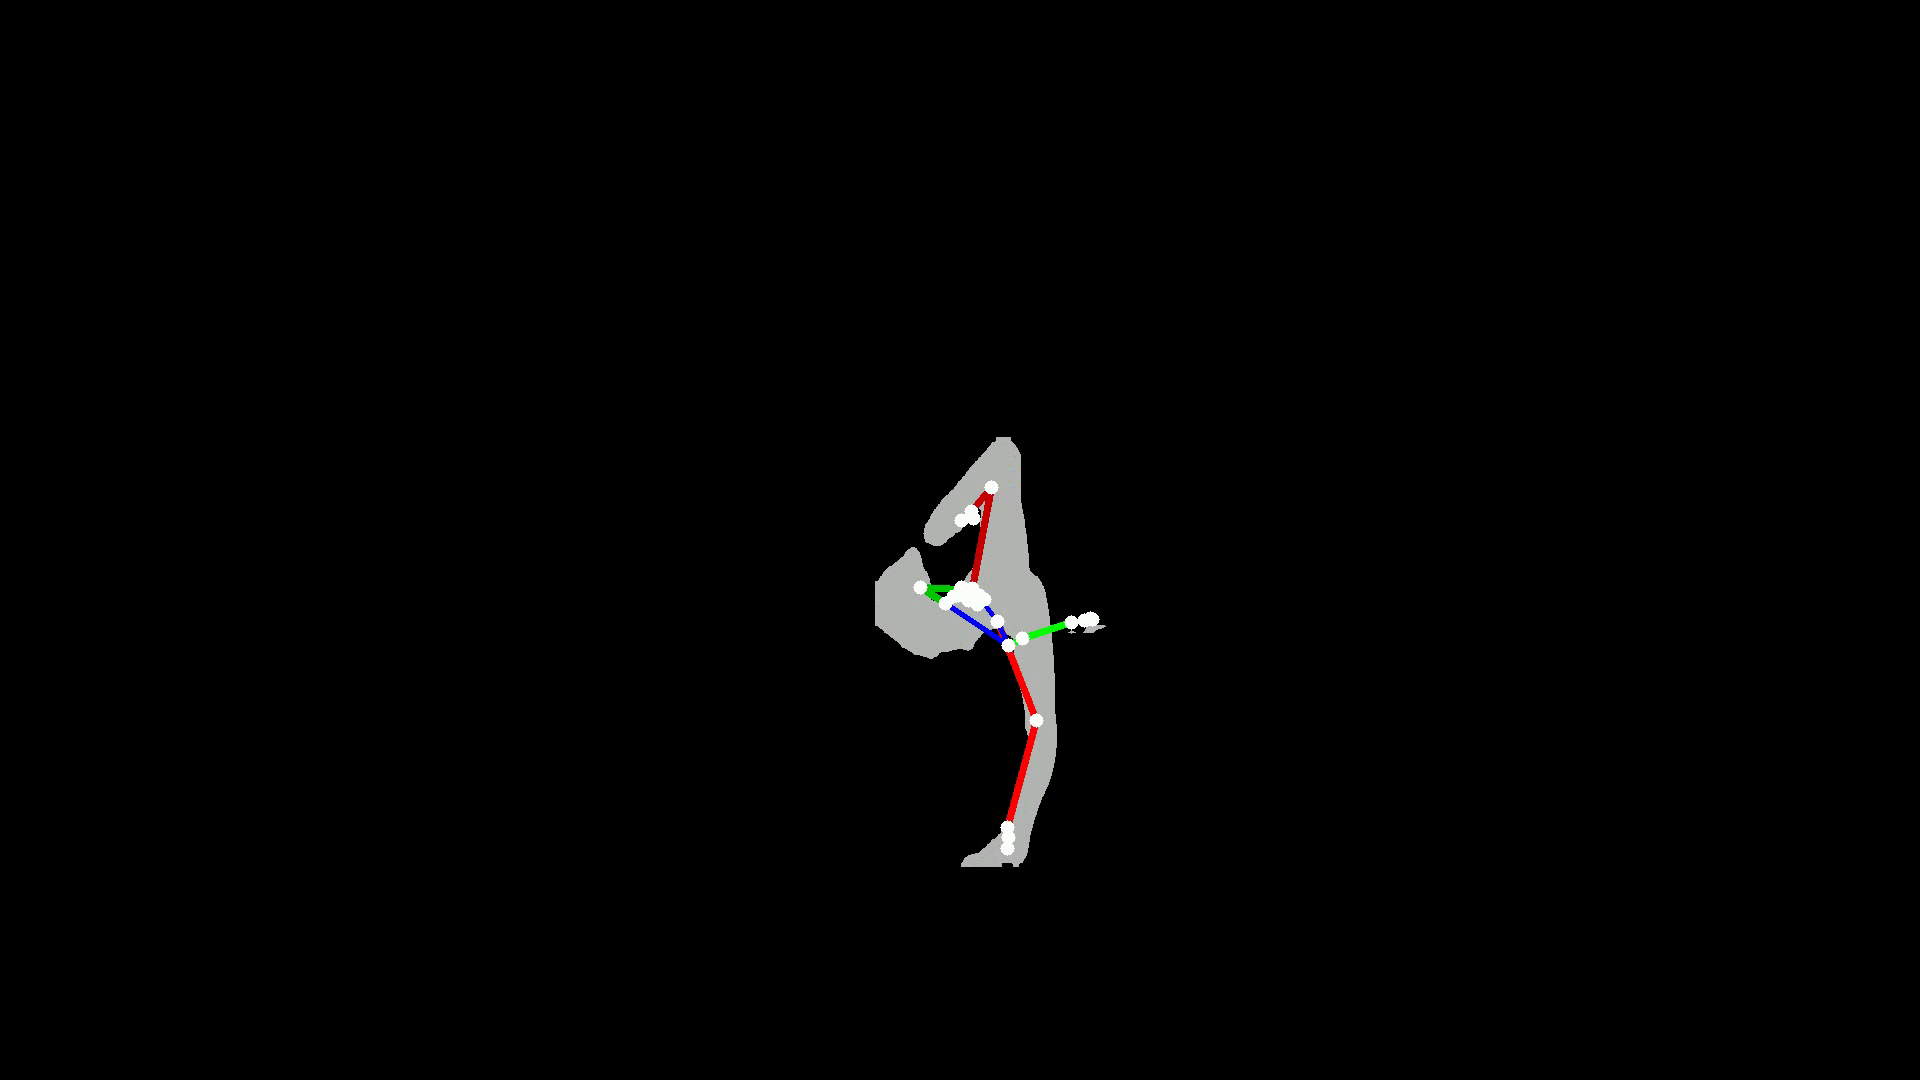

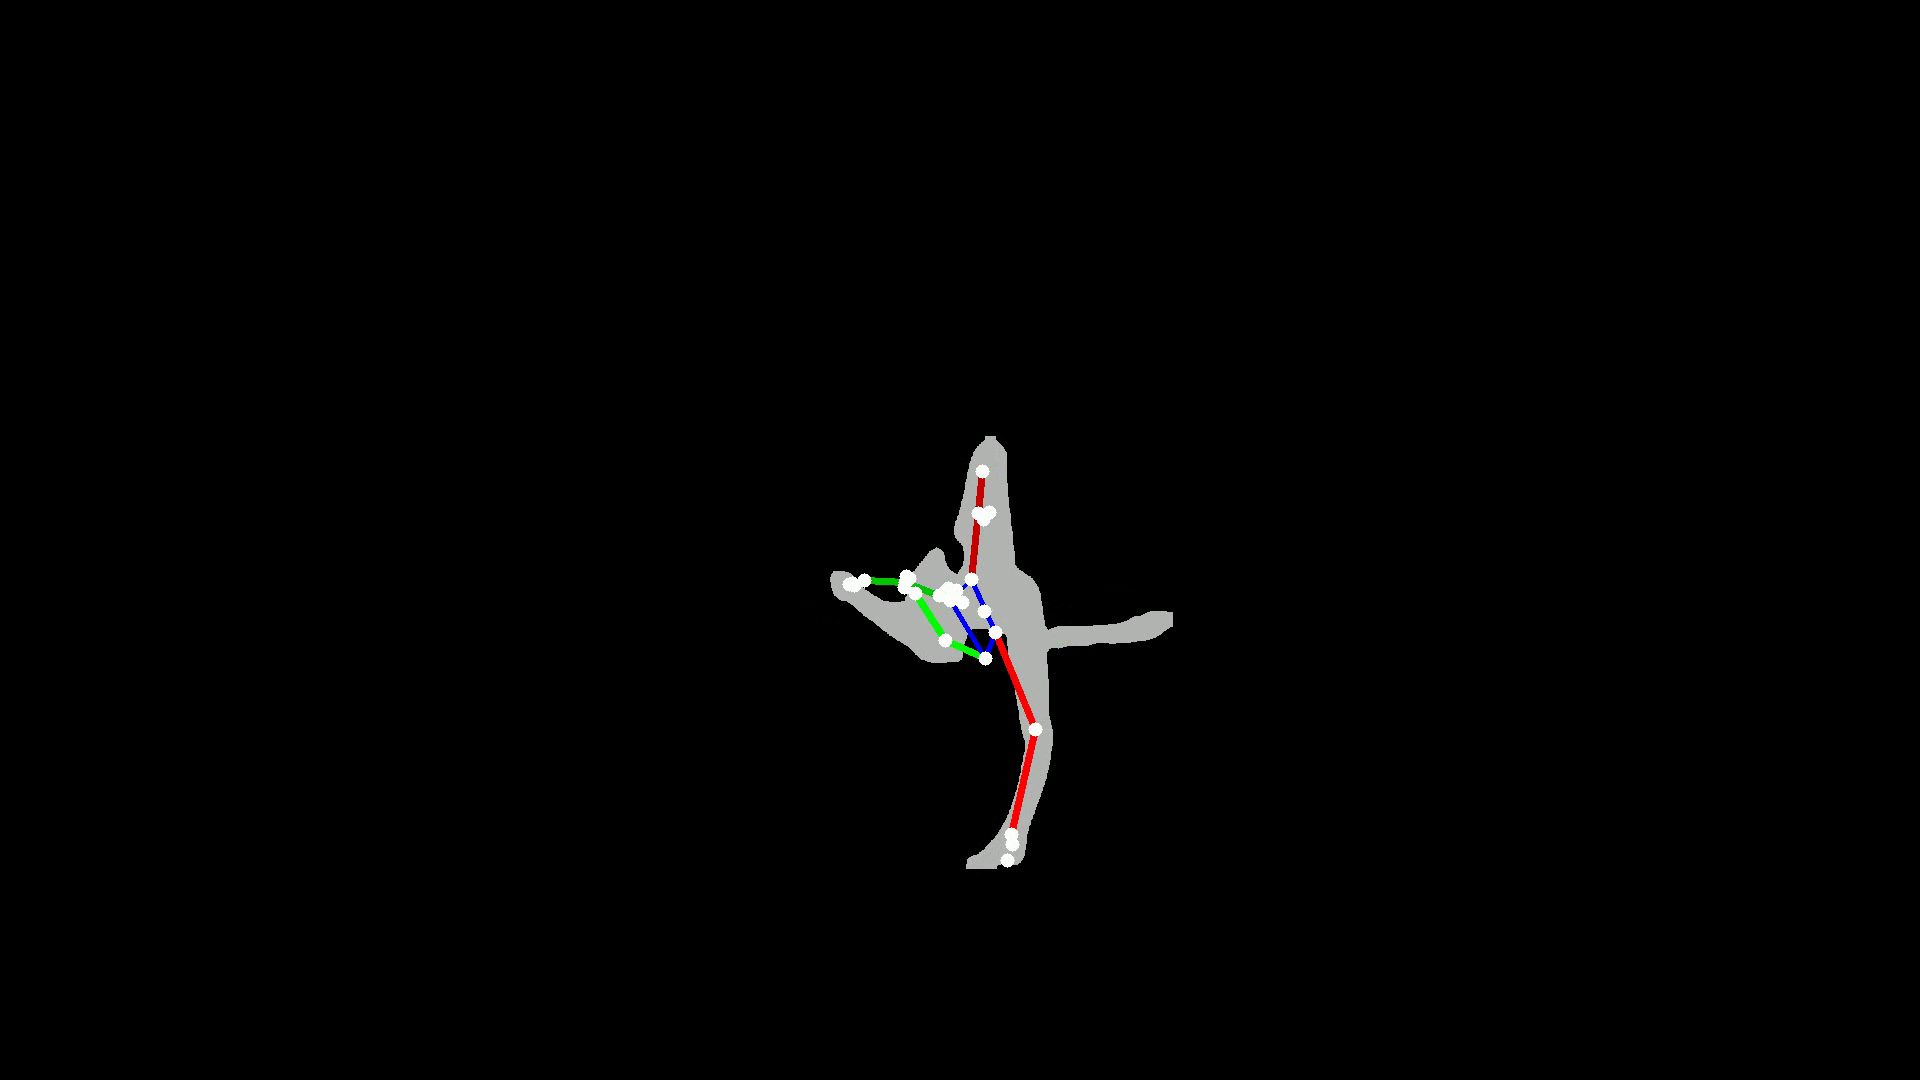

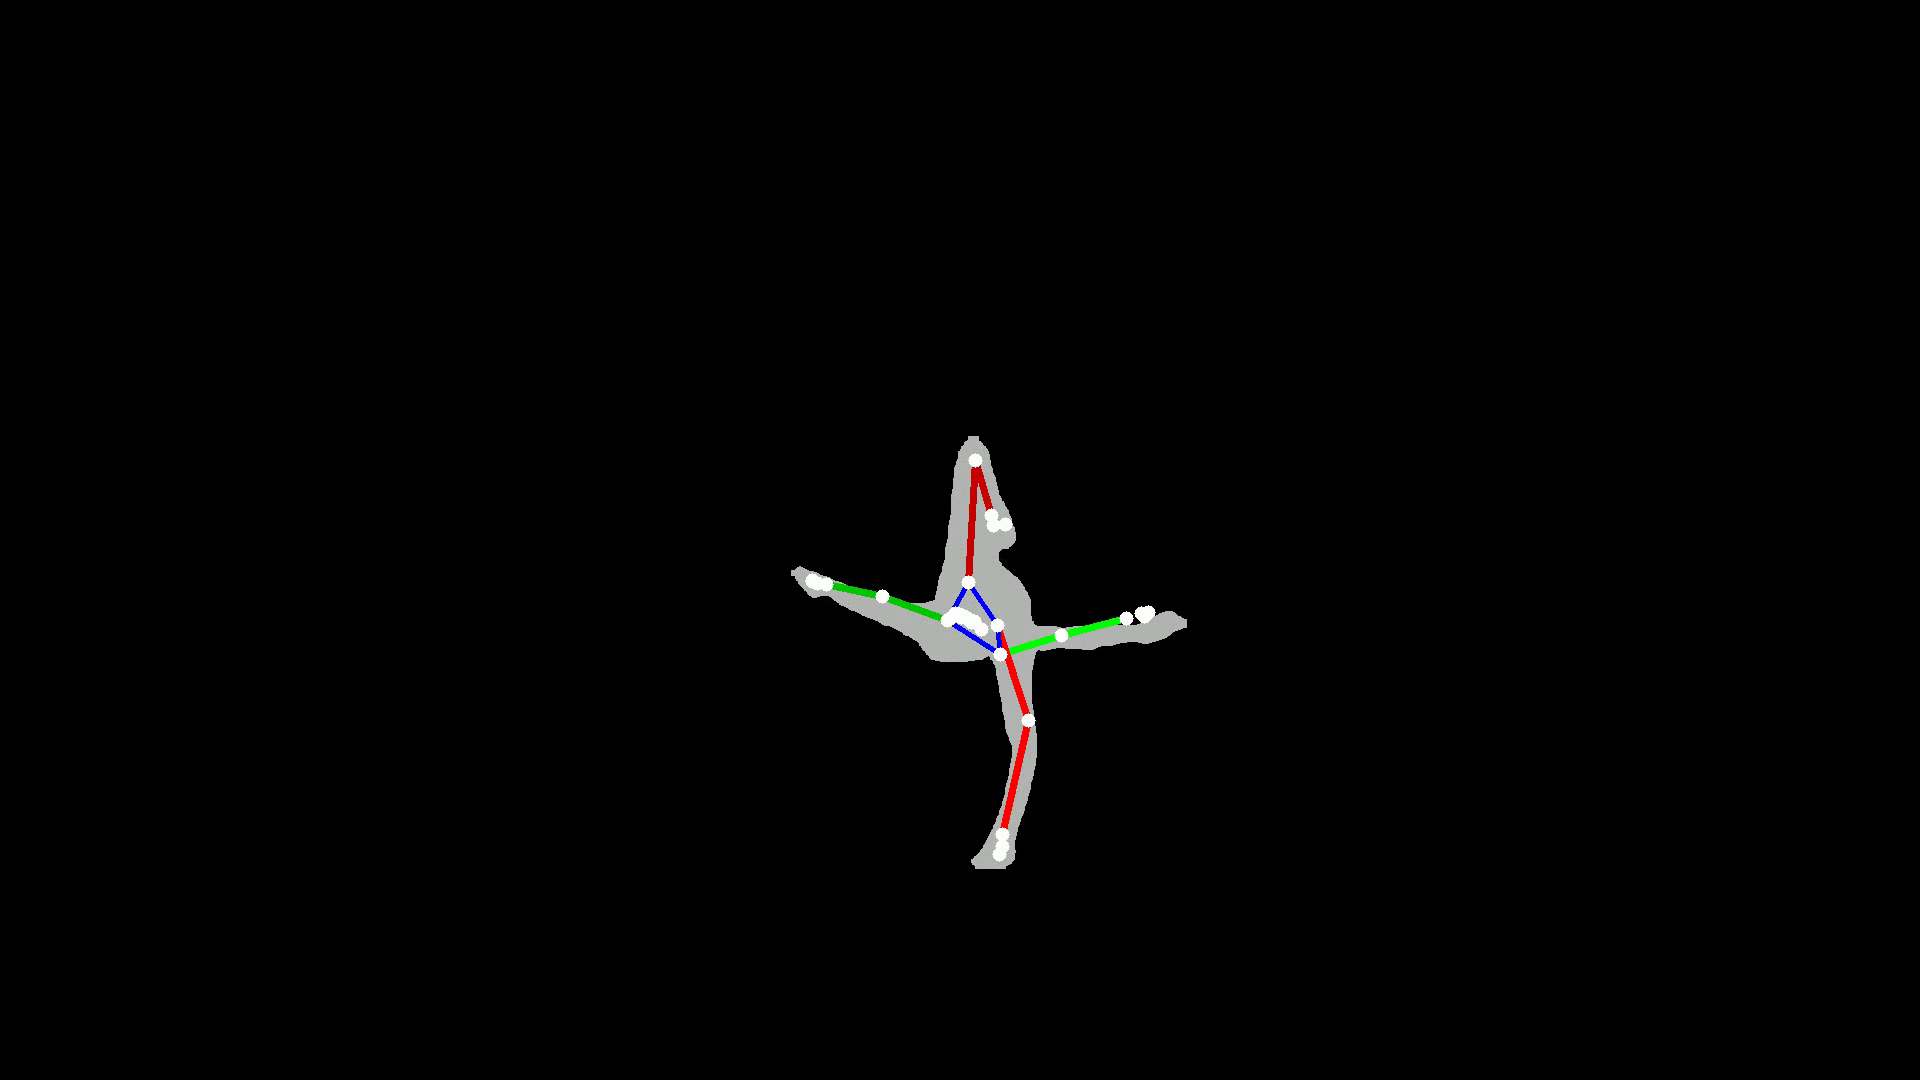

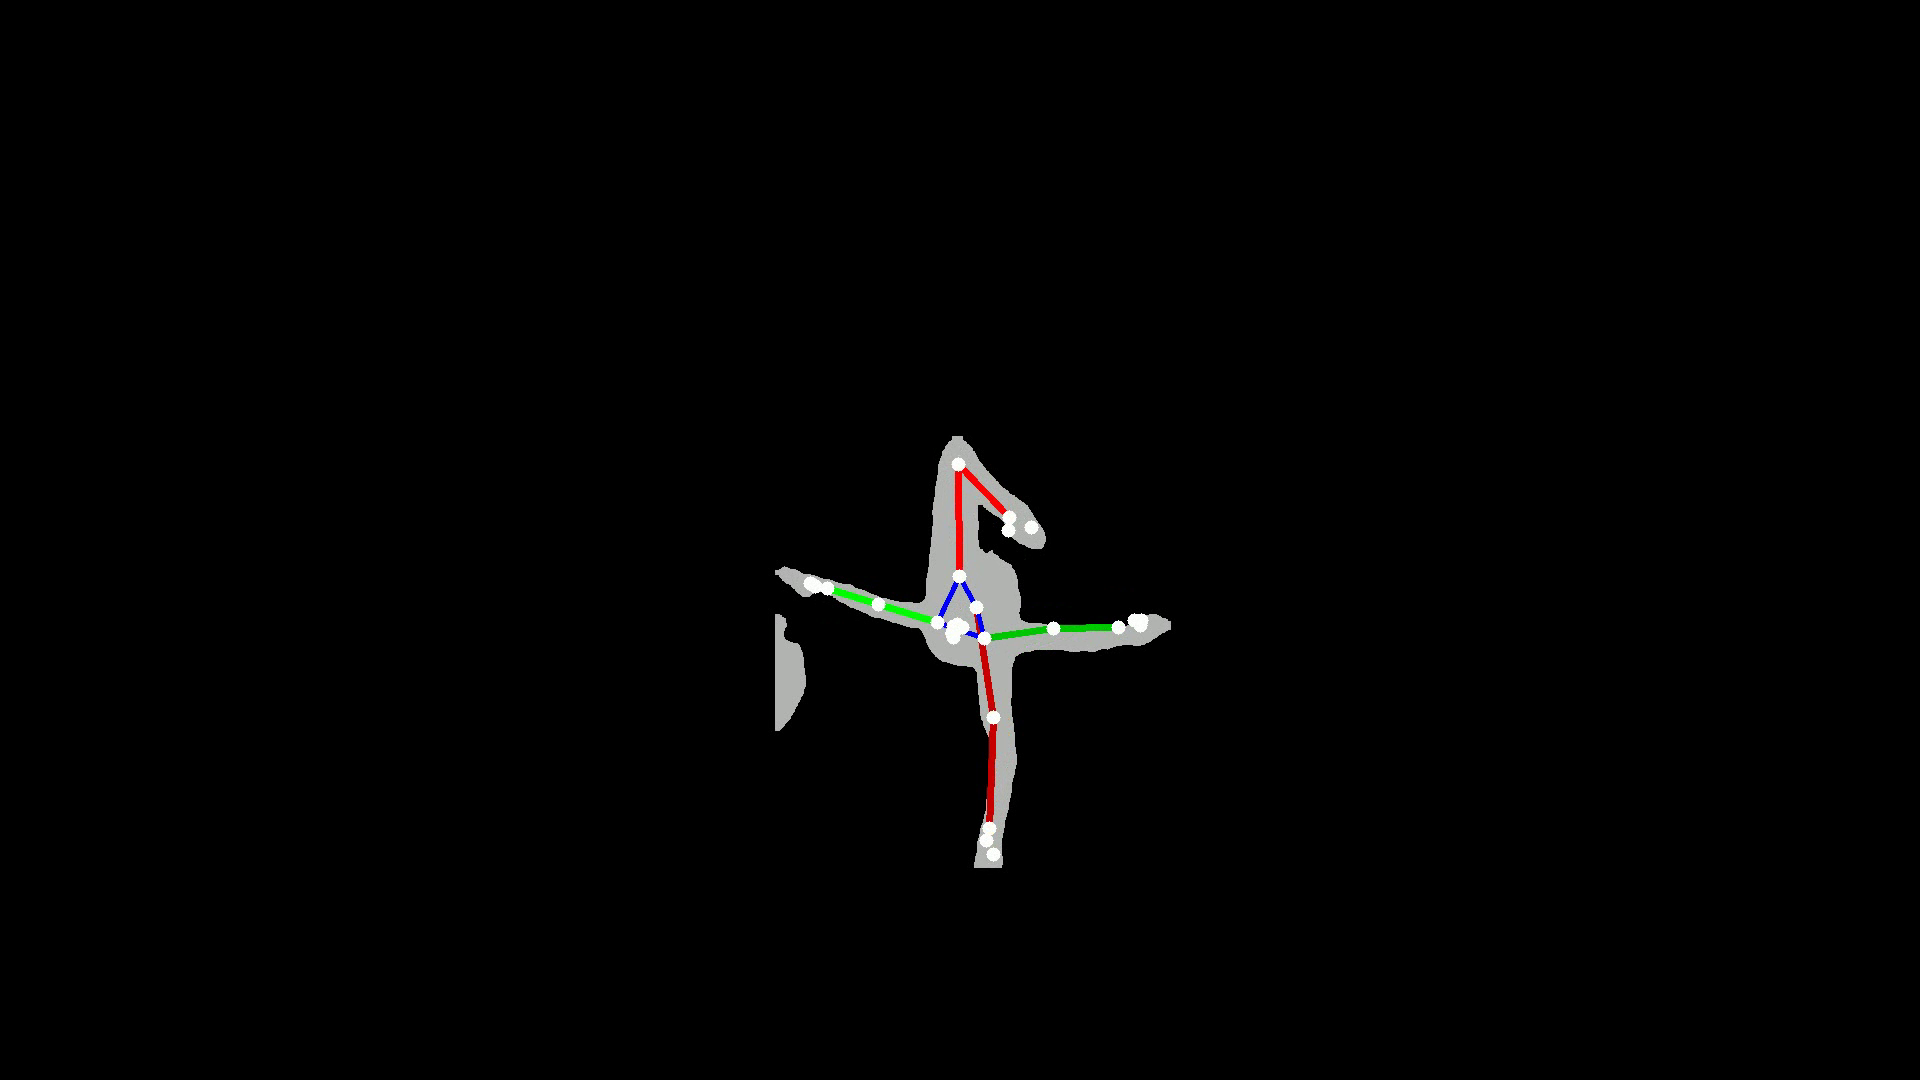

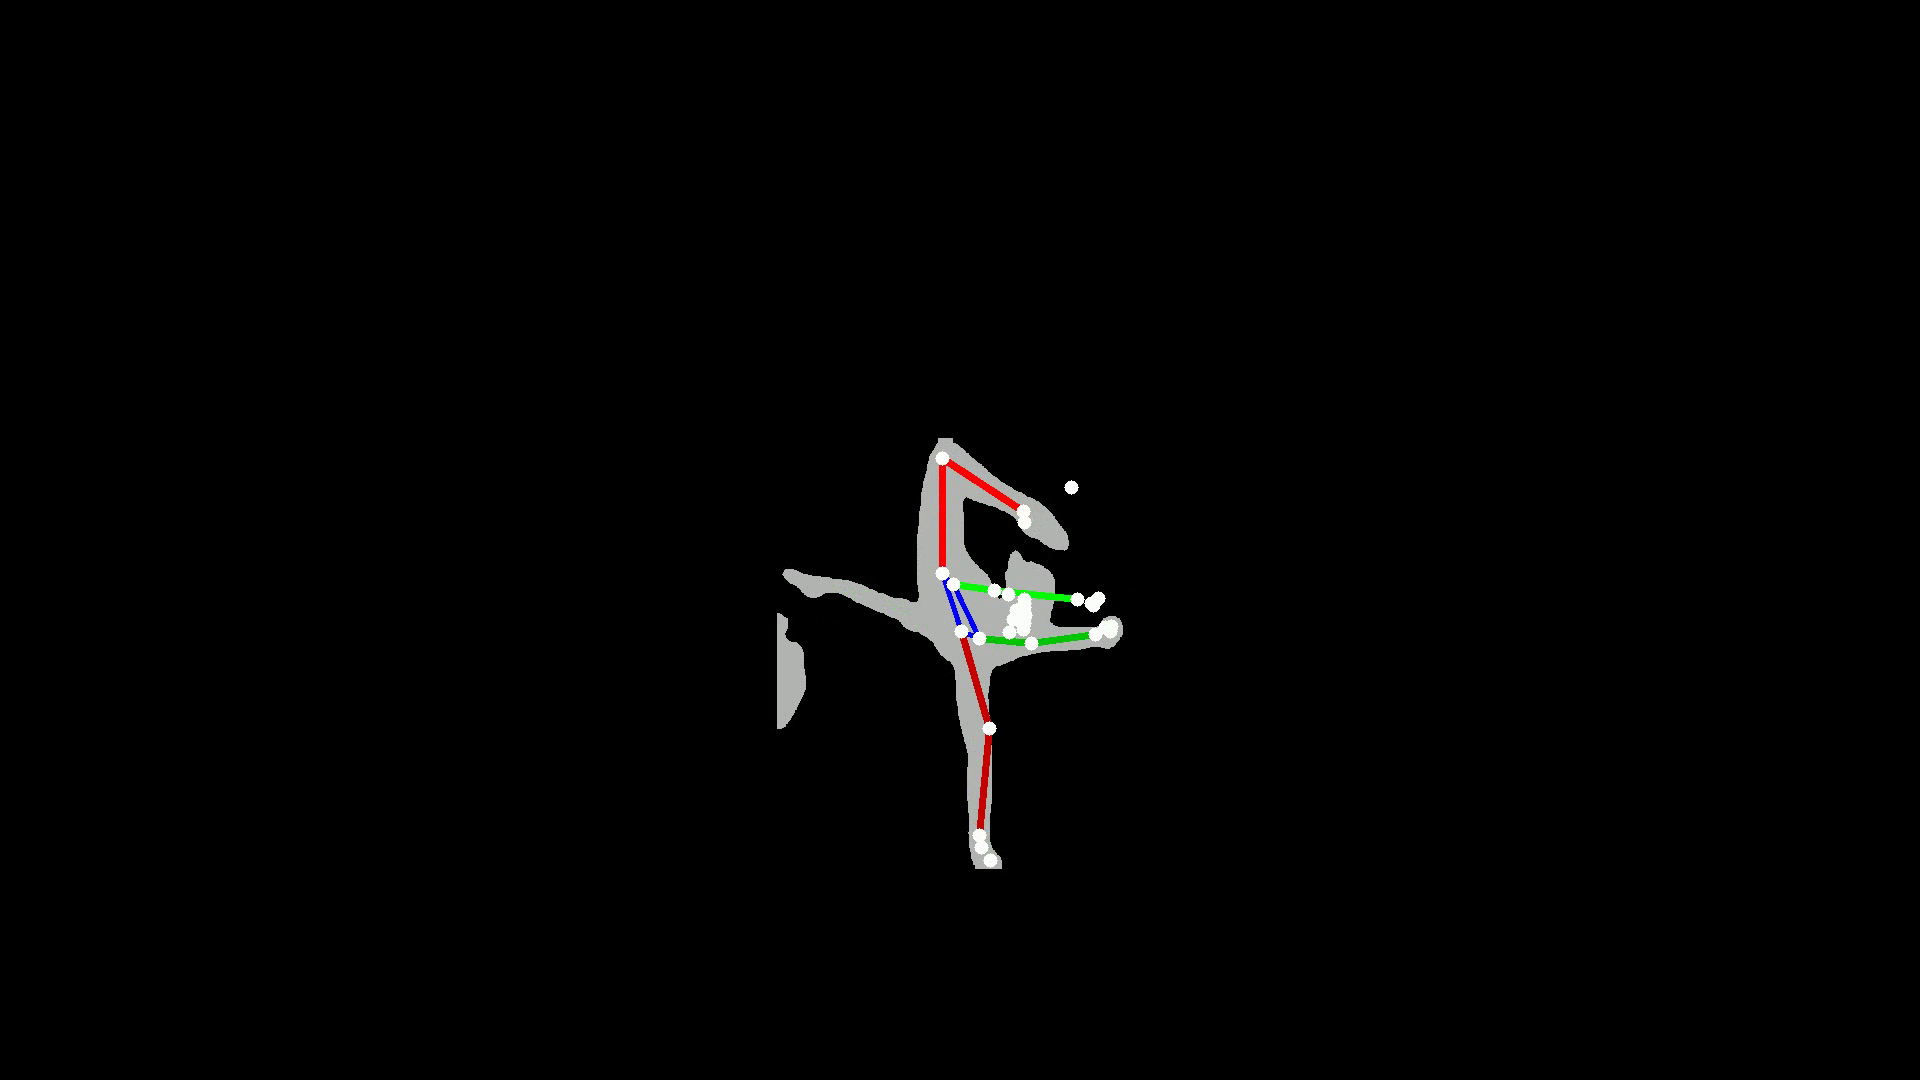

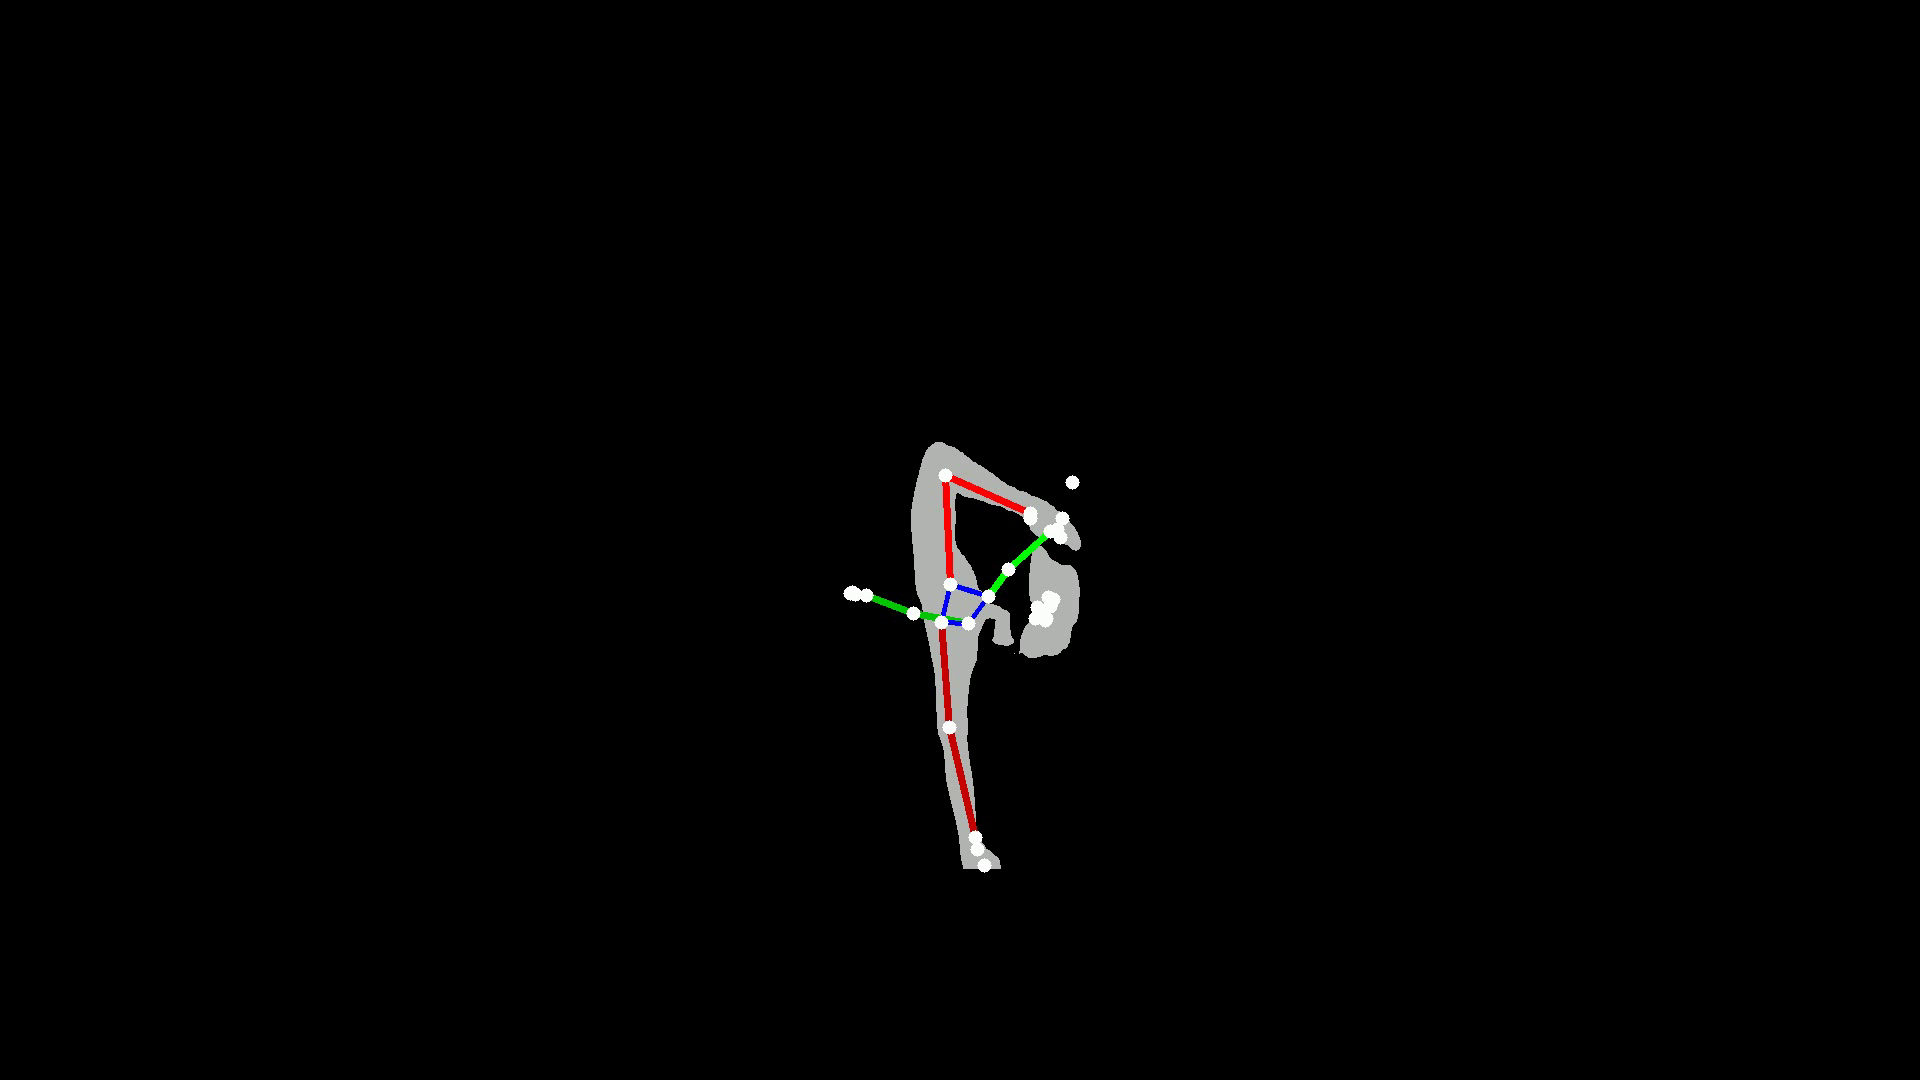

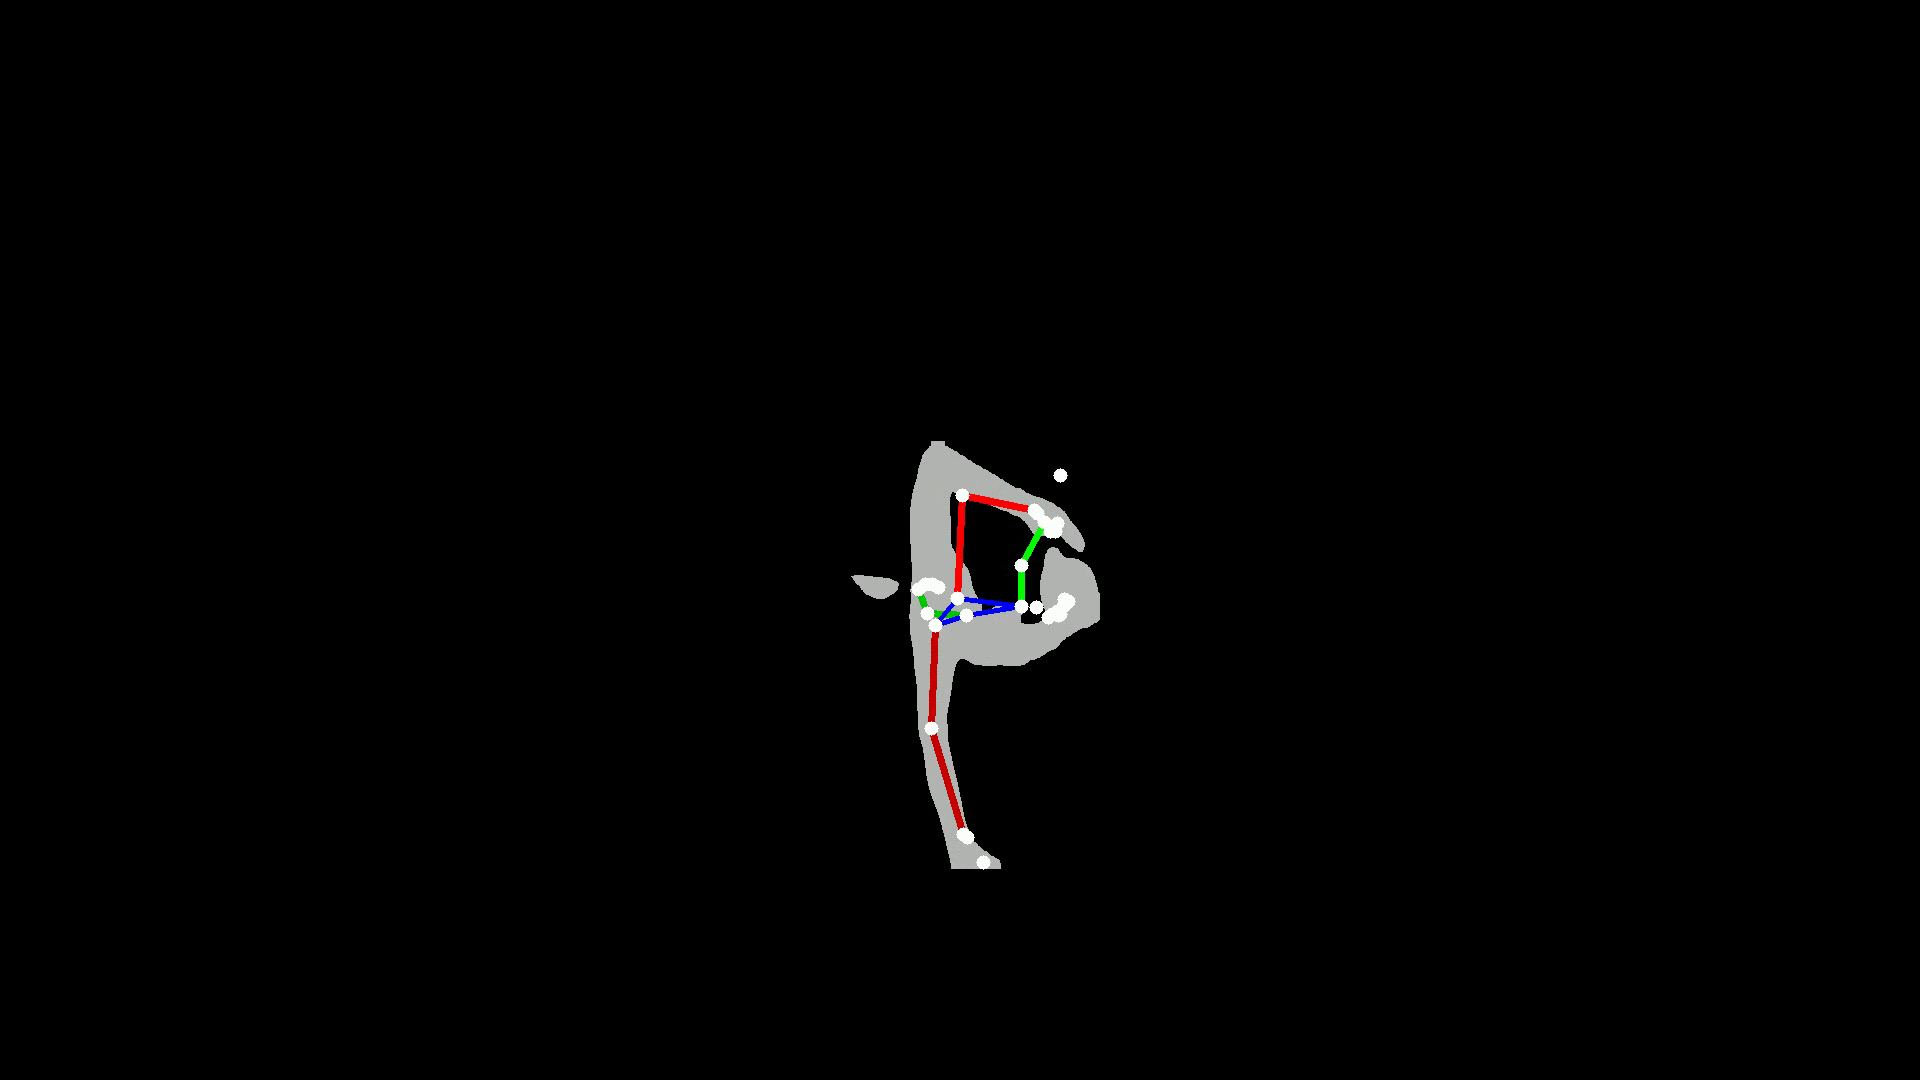

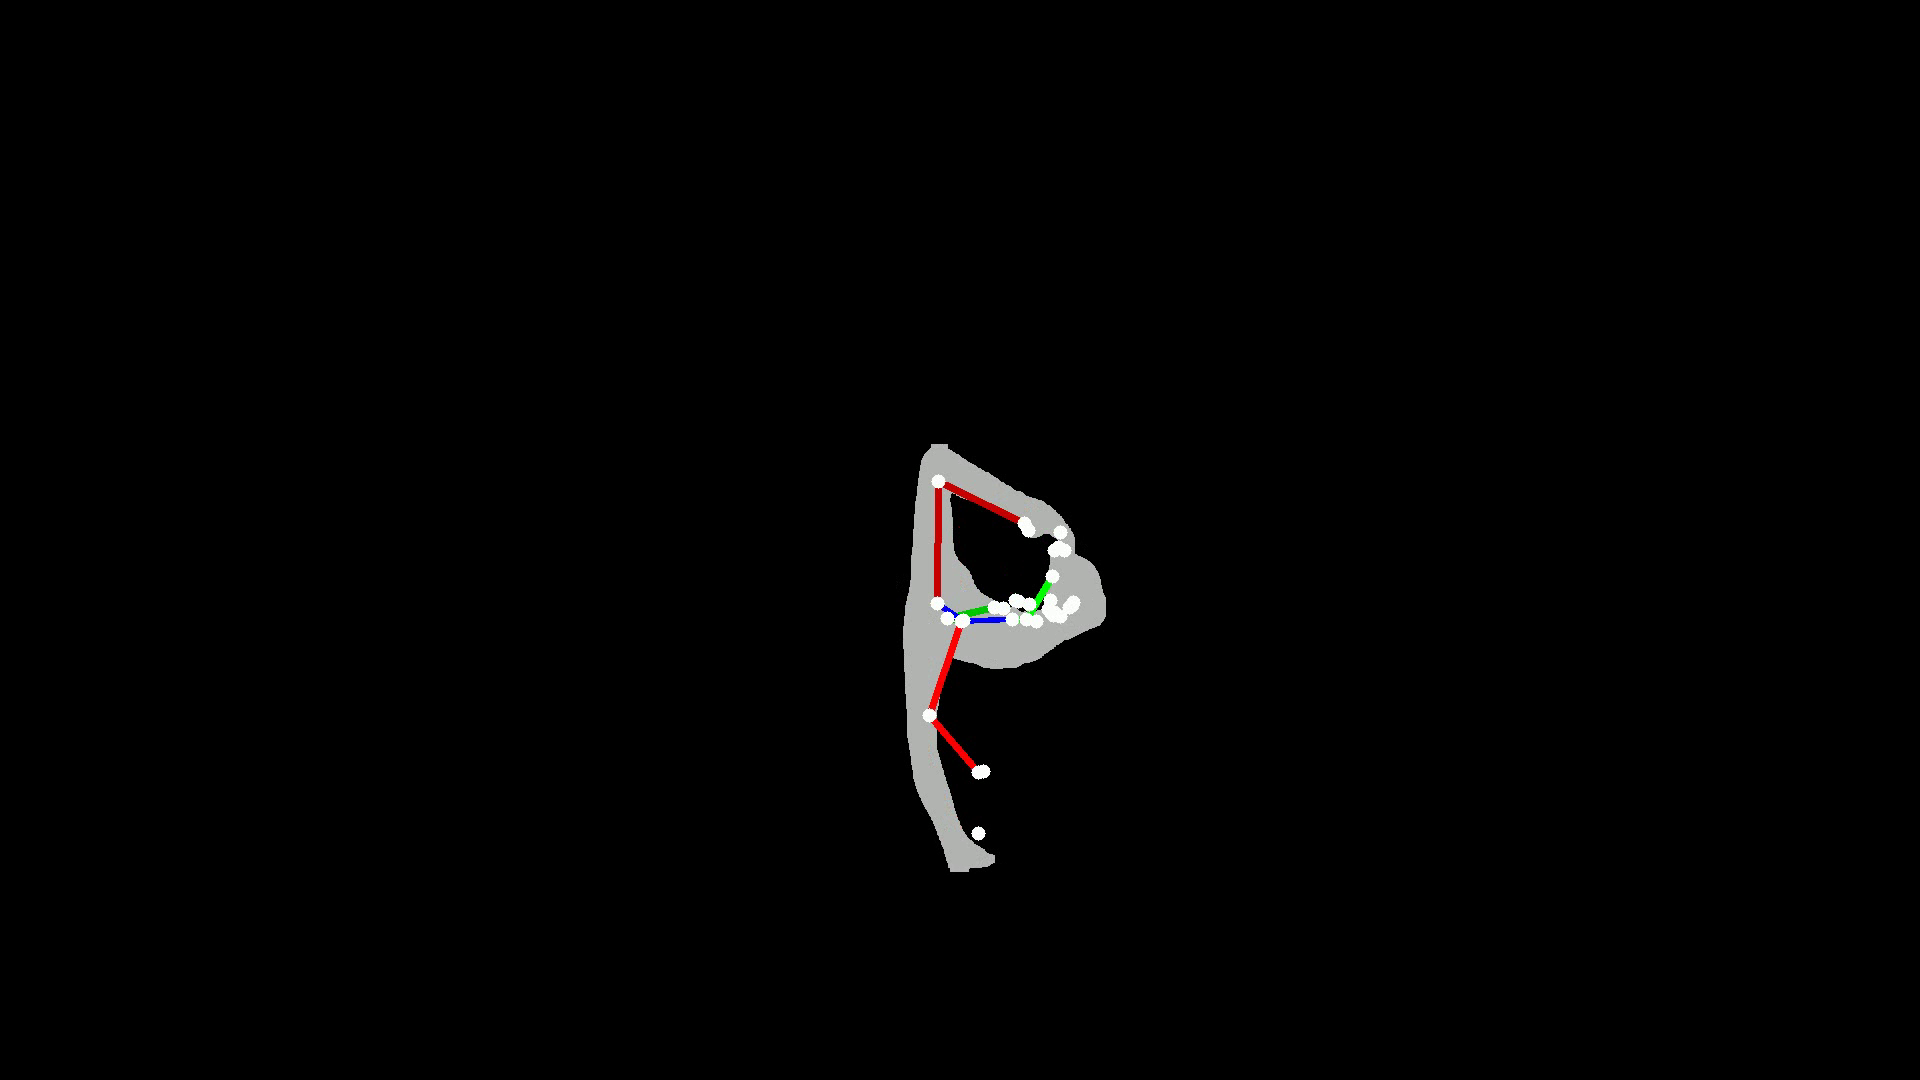

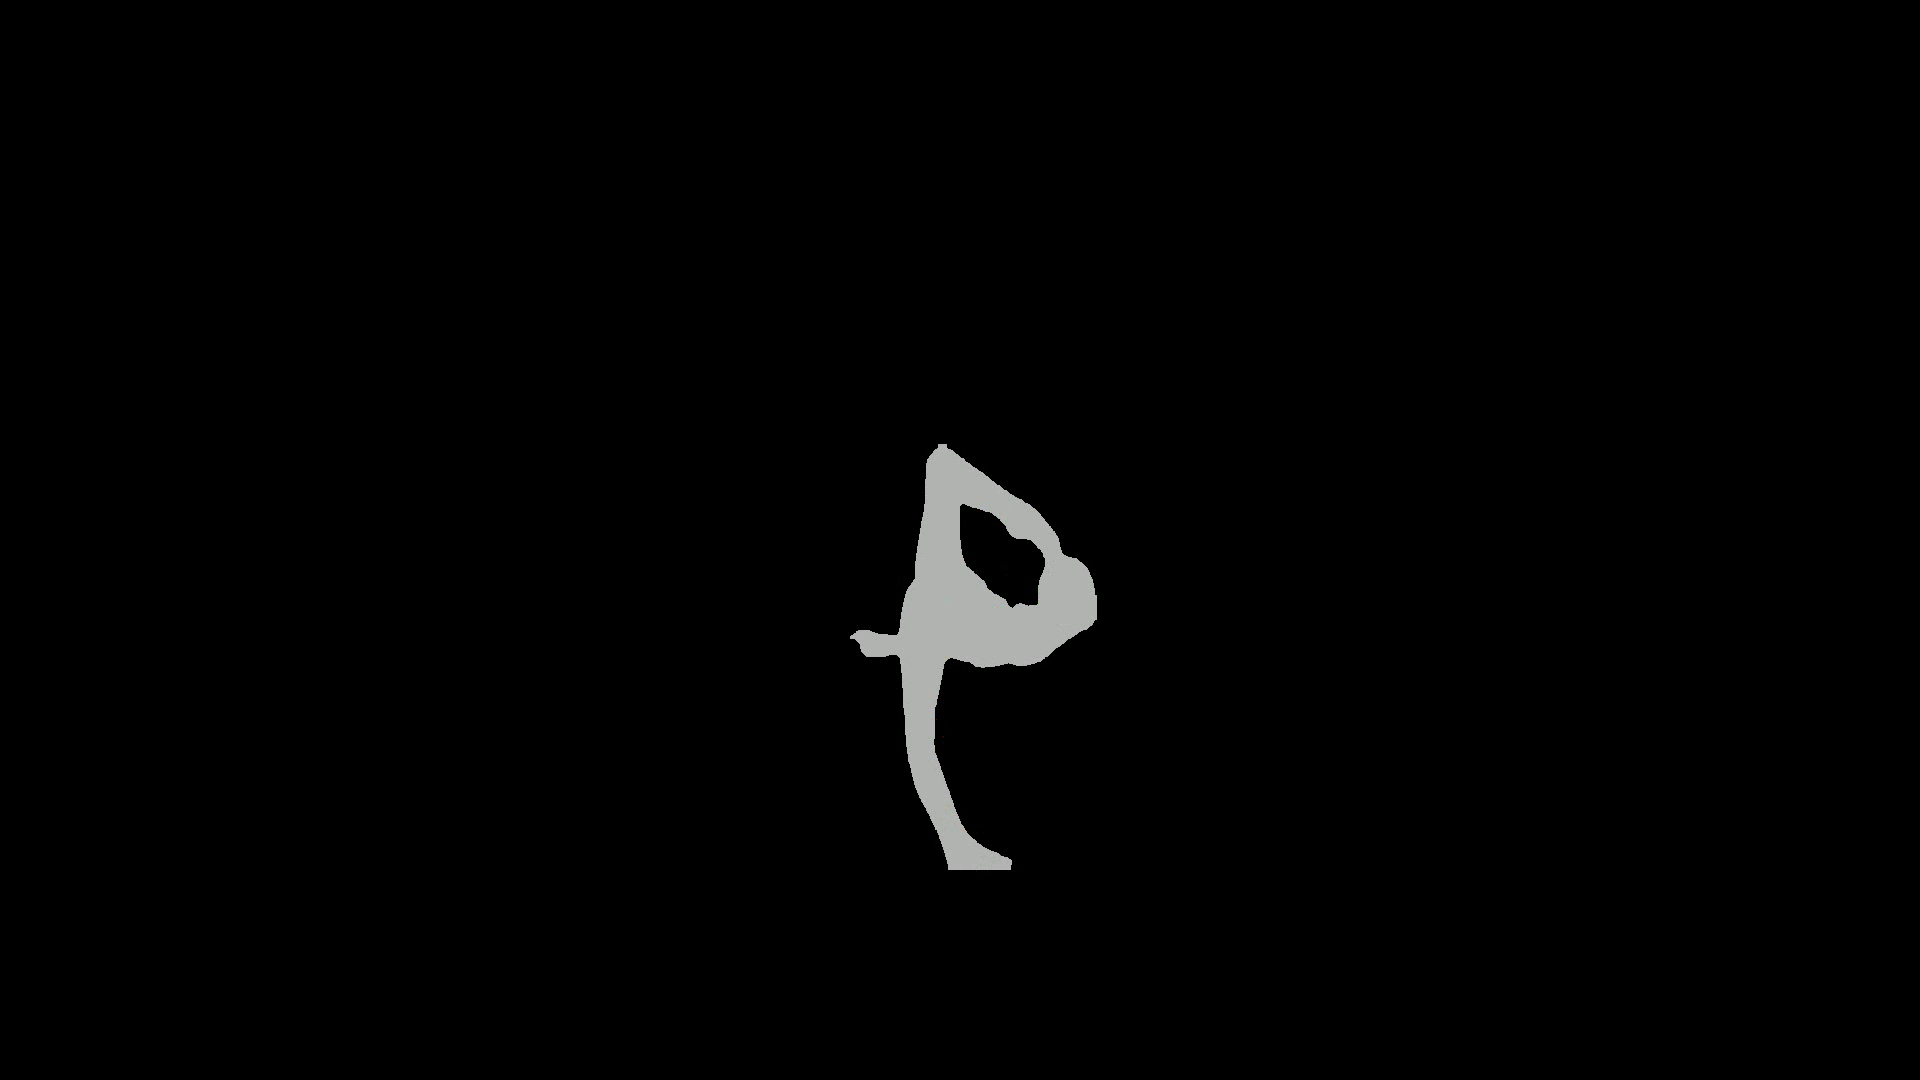

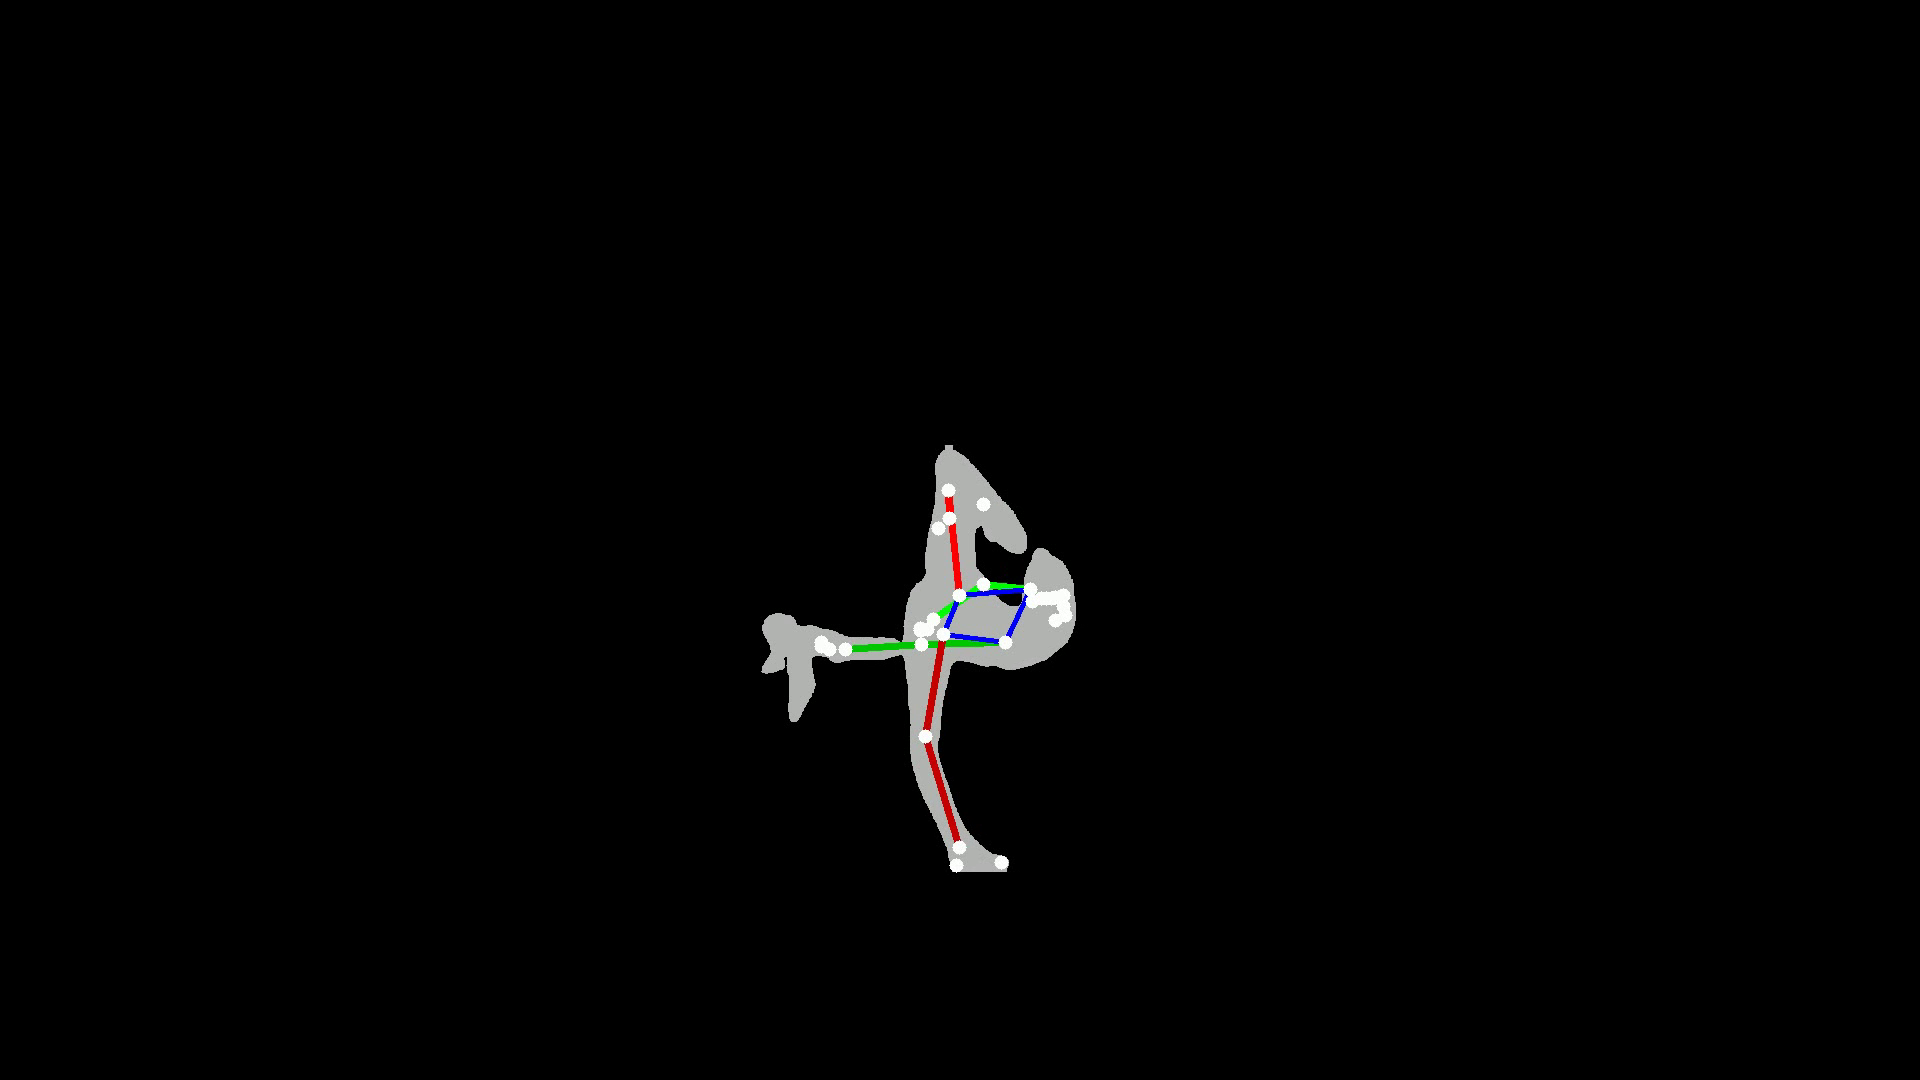

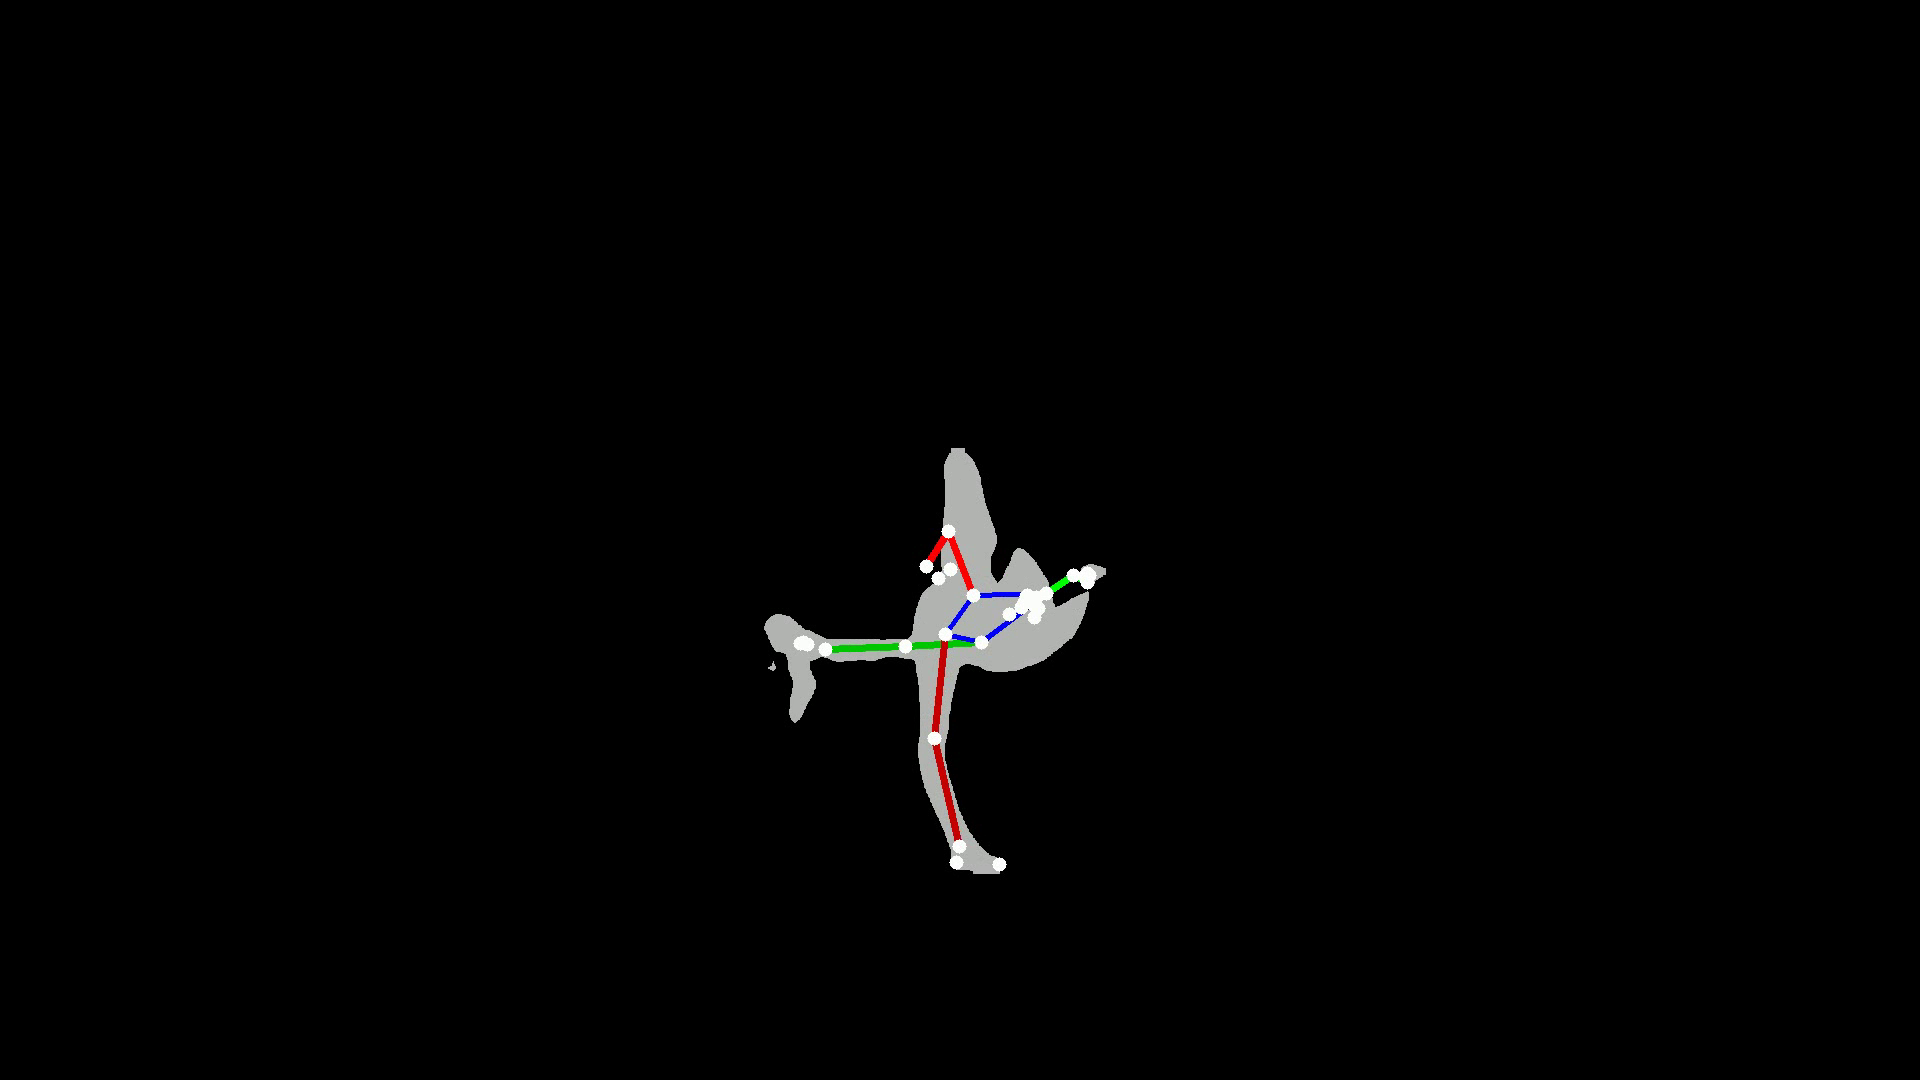

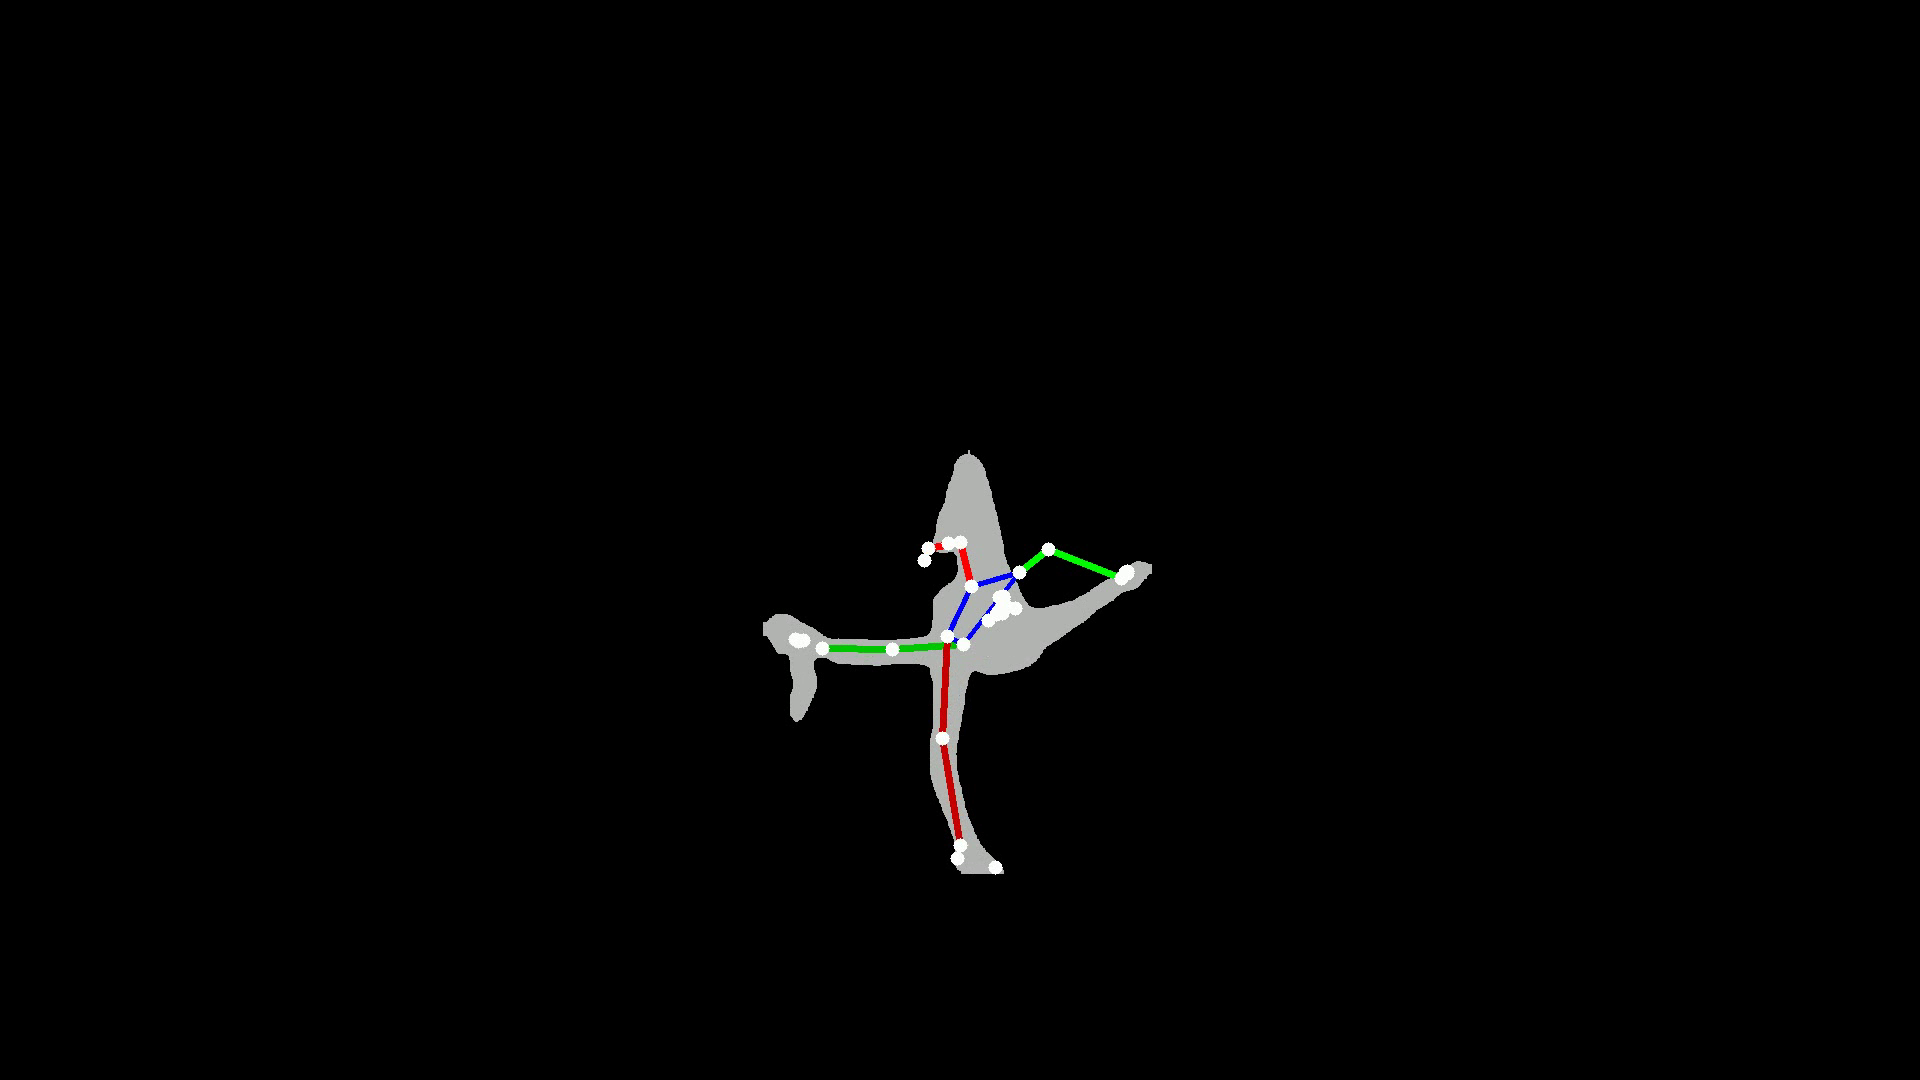

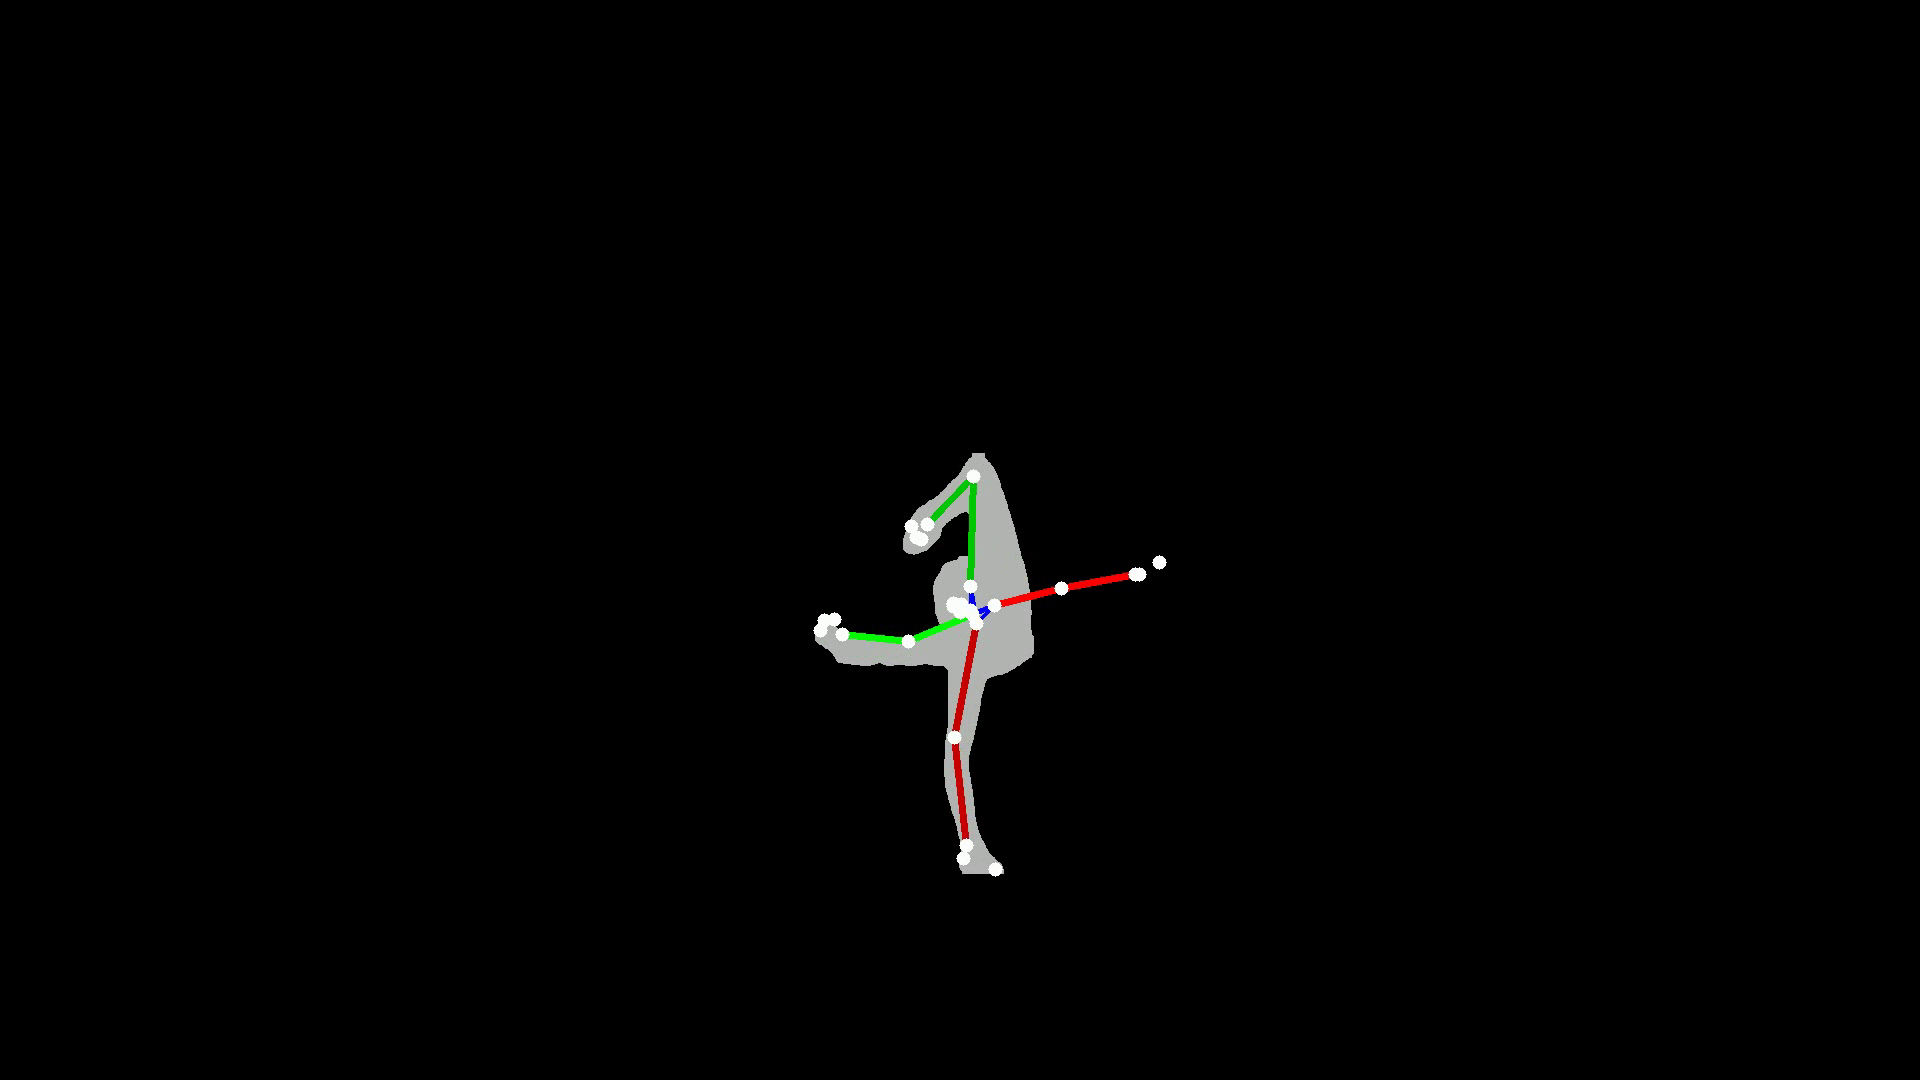

In [ ]:
true_label, pred_label = predict_video(model, video_path, test_dataset, device=device)
print(f'Истинный класс : {true_label}')
print(f'Предсказанный класс : {pred_label}')
play_video(video_path)